# Explainer Notebook: NYC Vehicular Collisions and Optimal Hospital Placement

#### Philip Frisch Møller s175387

In [1]:
# we start by importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import folium
from folium import  Marker
from folium.plugins import HeatMap, HeatMapWithTime
from IPython.display import IFrame
import plotly.express as px
from urllib.request import urlopen
import json
import webbrowser
import os
import math
from sklearn.cluster import KMeans
import bokeh
from bokeh.models import ColumnDataSource,FactorRange
from bokeh.plotting import figure, show, output_file


# we also modify matplotlibs default font
matplotlib.rc('font', serif='Helvetica Neue')

# define embedding function
def embed_map(m, file_name):
    # save file
    m.save(file_name)
    # open map in chrome
    webbrowser.open('file://' + os.path.realpath(file_name))
    return IFrame(file_name, width='100%', height='500px')

# Motivation

### Intro to dataset


The chosen topic is vehiuclar collisions in NYC. We will use the NYC Open Data set that contains all reported collisions occuring in NYC. Traffic accidents are the leading cause of death among people ages 5 to 29 and over 1.35 million people are killed every year globally as a result of traffic accidents. The data set contains the location of the collision, contributing factors and how many people were injured/killed during the collision. I have chosen to combine this dataset with another dataset that simply contains the location and name of all hospitals in NYC. This allows for analysis on the shortest distance to a hospital from all collisions to see if there is a connection between the fatality rates and the distance to nearest hospital. It is then interesting to look into where one would place new hospitals in the region to minimize average shortest distance to hospital.

The goal of the users experience is that the website should predominantly consist of data visualisations with minimal text. I also want the user to think about what is being shown and guide them towards their own conclusions. I also want to maximise the interactivity of the plots so that the user play around and investigate the visuals as they want. This is particularily relavent as there will be alot of geo heat maps that will allow for zooming in and panning around to really get a feel for the collisions frequency at different areas.

Below is the code used for importing the data as well as prepping some of the identifier flags used later on.

In [2]:
# importing collisions data
# https://medium.com/geekculture/proximity-analysis-using-python-ffd16c457f19
# data source: https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95

# define data path
data_path = 'data/Motor_Vehicle_Collisions_-_Crashes.csv'

# read data into dataframe
data = pd.read_csv(data_path, parse_dates=['CRASH DATE'], low_memory=False)

# splite date variable into temporal categories
data['year'] = pd.DatetimeIndex(data['CRASH DATE']).year
data['date'] = pd.DatetimeIndex(data['CRASH DATE']).date
data['month'] = pd.DatetimeIndex(data['CRASH DATE']).month
data['weekday'] = pd.DatetimeIndex(data['CRASH DATE']).weekday
data['hour'] = pd.DatetimeIndex(data['CRASH TIME']).hour
data['week_hour'] = data['weekday']*24 + data['hour']

# we are only interested in data where the location is registered
# filter out nan and 0's in location and Contributing factor of vehicle 1 not na
data = data[(data['LATITUDE']!=0) & data['LONGITUDE']!=0 & data['LOCATION'].notna() & data['CONTRIBUTING FACTOR VEHICLE 1'].notna()]

# filter out incomplete years
data = data[data['year']>=2013]
data = data[data['year']<=2022]

#
# create flag variables
# define flag function

def flag(x):
    if x != 0:
        result = 1
    else:
        result = 0
    return result

# apply flag function
data['PERSON INJURED FLAG'] = data['NUMBER OF PERSONS INJURED'].apply(flag)
data['PERSON KILLED FLAG'] = data['NUMBER OF PERSONS KILLED'].apply(flag)
data['CYCLIST INJURED FLAG'] = data['NUMBER OF CYCLIST INJURED'].apply(flag)
data['CYCLIST KILLED FLAG'] = data['NUMBER OF CYCLIST KILLED'].apply(flag)
data['PEDESTRIAN INJURED FLAG'] = data['NUMBER OF PEDESTRIANS INJURED'].apply(flag)
data['PEDESTRIAN KILLED FLAG'] = data['NUMBER OF PEDESTRIANS KILLED'].apply(flag)
data['MOTORIST INJURED FLAG'] = data['NUMBER OF MOTORIST INJURED'].apply(flag)
data['MOTORIST KILLED FLAG'] = data['NUMBER OF MOTORIST KILLED'].apply(flag)

# "serious" collisions are only considered, i.e either death or injury
data_all = data
data = data[(data['PERSON KILLED FLAG']==1) | (data['PERSON INJURED FLAG']==1)]

# print number of rows
print(f'Data contains {np.shape(data)[0]} unique vehicle collions')

# import hospital data
# source https://data.cityofnewyork.us/Health/Hospitals/833h-xwsx
# define data path
data_path_hospitals = 'data/Hospitals.csv'

# read data into dataframe
data_hospitals = pd.read_csv(data_path_hospitals,delimiter=';')
# extract coordinates from Location 1
def extract_coordinates(s):
    result = s[s.find("(")+1:s.find(")")]
    return result

data_hospitals['coordinates'] = data_hospitals['Location 1'].apply(extract_coordinates)
data_hospitals[['lat', 'lon']] = ((data_hospitals['coordinates'].astype(str)).str.split(',', expand=True).astype(float))\

# we are only interested in 'accute care hospitals' 
data_hospitals = data_hospitals[data_hospitals['Facility Type']=='Acute Care Hospital'].reset_index(drop=True)
print(f'Data contains {np.shape(data_hospitals)[0]} unique Hospitals')

Data contains 363439 unique vehicle collions
Data contains 11 unique Hospitals


### Data Cleaning and Processing

I have filtered all incomplete years out of the data, this means that the data only contains collisions that occur between 2013 to 2022 which includes 363,439 unique collisions. I have also chosen to focus solely on "severe" collisison that include either a fatality or injury or both. This way we neglect "fender benders" that probably do not need ambulances to be called in. On the hospital side, I have only taken hospitals that fall under the category of 'acute care hospitals' as these were likely the hospitals that could severe traffic accidents. The filters are also included in the above code.

### Exploratory Analysis

We start by plotting pie charts for visualising victim splits in both fatal and nonfatal collisions.

In [3]:
# pie charts that show victim death and injury splits
# prepare data for deaths
victim_pie_data = pd.DataFrame({'MOTORIST KILLED' : [np.sum(data['NUMBER OF MOTORIST KILLED'])],'PEDESTRIAN KILLED' : [np.sum(data['NUMBER OF PEDESTRIANS KILLED'])],'CYCLIST KILLED': [np.sum(data['NUMBER OF CYCLIST KILLED'])]})
victim_pie_data = victim_pie_data.T.reset_index()
victim_pie_data = victim_pie_data.rename(columns={'index':'Type',0 : 'NumberOfKilled'})
# plot pie chart
fig = px.pie(victim_pie_data, values='NumberOfKilled', names='Type', title='People Killed in Vehicular Collisions',color_discrete_sequence=px.colors.diverging.PRGn)
fig.write_html("killedpie.html")
fig.show()

# prepare data for injury
victim_pie_data = pd.DataFrame({'MOTORIST INJURED' : [np.sum(data['NUMBER OF MOTORIST INJURED'])],'PEDESTRIAN INJURED' : [np.sum(data['NUMBER OF PEDESTRIANS INJURED'])],'CYCLIST INJURED': [np.sum(data['NUMBER OF CYCLIST INJURED'])]})
victim_pie_data = victim_pie_data.T.reset_index()
victim_pie_data = victim_pie_data.rename(columns={'index':'Type',0 : 'NumberOfInjured'})
# plot pie chart
fig = px.pie(victim_pie_data, values='NumberOfInjured', names='Type', title='People Injured in Vehicular Collisions',color_discrete_sequence=px.colors.diverging.PRGn)
fig.write_html("injuredpie.html")
fig.show()

In the above pie charts we see that pedestrians are killed the most frequently, closely followed by motorists. Motorists are far more likely to be injured rather than killed in collisions. In NYC alone, 2,247 people have lost their lives on the streets due to traffic accidents from 2013 to 2022. 485,445 have similarily been injured. 

Basic time series plots aim to show any temporal tendencies in the data. Below is the code for ploting the amount of collisions that result in injury and death as functions of time.

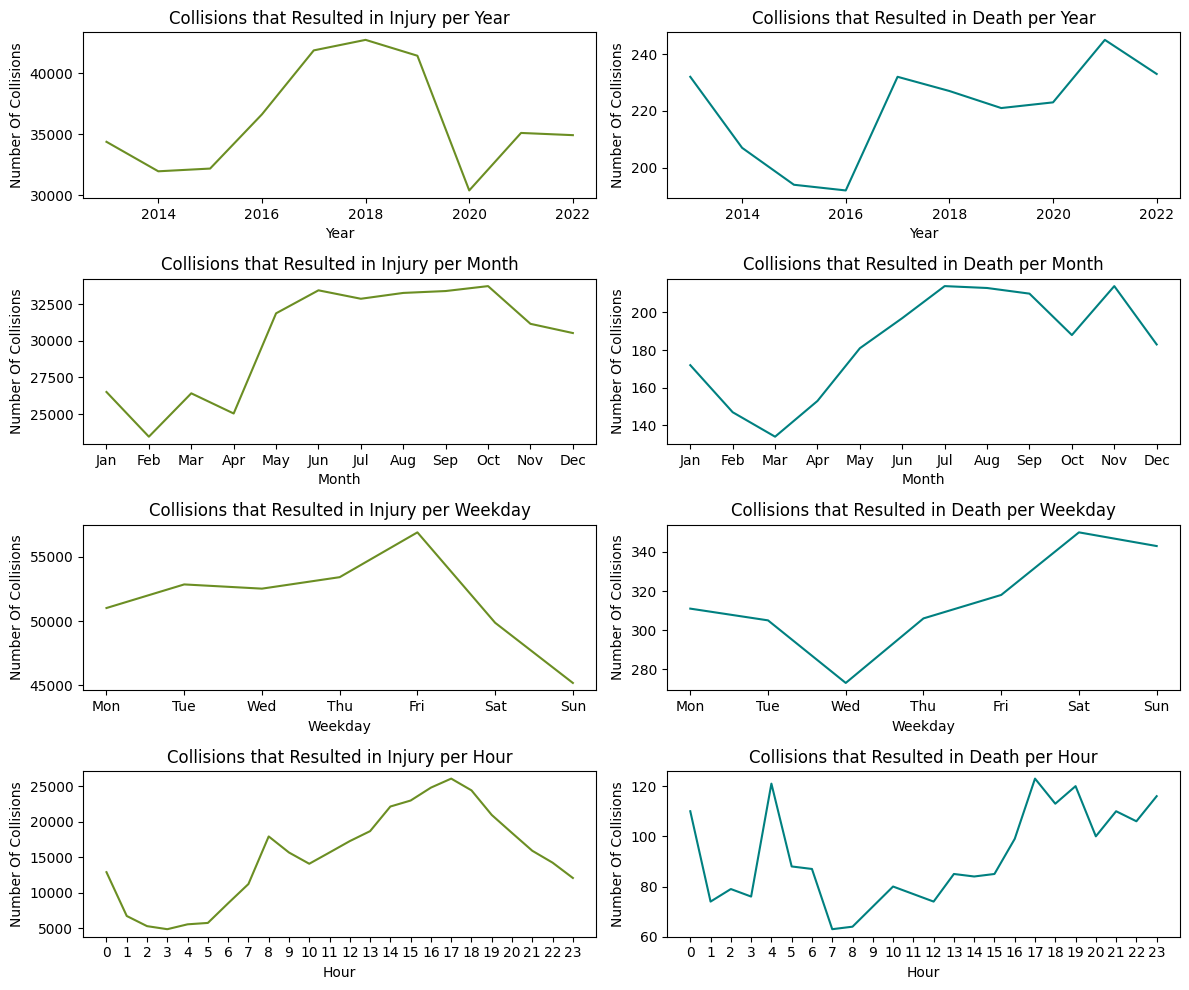

In [4]:
# Occurances as a time series
# prepare data
df_Injured = data[data['PERSON INJURED FLAG']==1] 
df_Killed = data[data['PERSON KILLED FLAG']==1] 

df_CollisionsPerYearTotal = data[['COLLISION_ID','year']].groupby('year').count()
df_CollisionsPerMonthTotal = data[['COLLISION_ID','month']].groupby('month').count()
df_CollisionsPerWeekdayTotal = data[['COLLISION_ID','weekday']].groupby('weekday').count()
df_CollisionsPerHourTotal = data[['COLLISION_ID','hour']].groupby('hour').count()

df_CollisionsPerYear_Injured = df_Injured[['COLLISION_ID','year']].groupby('year').count()
df_CollisionsPerMonth_Injured = df_Injured[['COLLISION_ID','month']].groupby('month').count()
df_CollisionsPerWeekday_Injured = df_Injured[['COLLISION_ID','weekday']].groupby('weekday').count()
df_CollisionsPerHour_Injured = df_Injured[['COLLISION_ID','hour']].groupby('hour').count()

df_CollisionsPerYear_Killed = df_Killed[['COLLISION_ID','year']].groupby('year').count()
df_CollisionsPerMonth_Killed = df_Killed[['COLLISION_ID','month']].groupby('month').count()
df_CollisionsPerWeekday_Killed = df_Killed[['COLLISION_ID','weekday']].groupby('weekday').count()
df_CollisionsPerHour_Killed = df_Killed[['COLLISION_ID','hour']].groupby('hour').count()

# prepare plots
fig, axs = plt.subplots(4, 2, figsize=(12,10), tight_layout=True)

axs[0,0].plot(df_CollisionsPerYear_Injured.index,df_CollisionsPerYear_Injured['COLLISION_ID'], color='olivedrab')
axs[0,0].set_title('Collisions that Resulted in Injury per Year')
axs[0,0].set_xlabel('Year')
axs[0,0].set_ylabel('Number Of Collisions')

axs[1,0].plot(df_CollisionsPerMonth_Injured.index,df_CollisionsPerMonth_Injured['COLLISION_ID'], color='olivedrab')
axs[1,0].set_title('Collisions that Resulted in Injury per Month')
axs[1,0].set_xlabel('Month')
axs[1,0].set_ylabel('Number Of Collisions')
axs[1,0].set_xticks([1,2,3,4,5,6,7,8,9,10,11,12], ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])

axs[2,0].plot(df_CollisionsPerWeekday_Injured.index,df_CollisionsPerWeekday_Injured['COLLISION_ID'], color='olivedrab')
axs[2,0].set_title('Collisions that Resulted in Injury per Weekday')
axs[2,0].set_xlabel('Weekday')
axs[2,0].set_ylabel('Number Of Collisions')
axs[2,0].set_xticks([0, 1, 2, 3, 4, 5, 6], ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])

axs[3,0].plot(df_CollisionsPerHour_Injured.index,df_CollisionsPerHour_Injured['COLLISION_ID'], color='olivedrab')
axs[3,0].set_xlabel('Hour')
axs[3,0].set_title('Collisions that Resulted in Injury per Hour')
axs[3,0].set_ylabel('Number Of Collisions')
axs[3,0].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]) 

axs[0,1].plot(df_CollisionsPerYear_Killed.index,df_CollisionsPerYear_Killed['COLLISION_ID'], color='teal')
axs[0,1].set_title('Collisions that Resulted in Death per Year')
axs[0,1].set_xlabel('Year')
axs[0,1].set_ylabel('Number Of Collisions')

axs[1,1].plot(df_CollisionsPerMonth_Killed.index,df_CollisionsPerMonth_Killed['COLLISION_ID'], color='teal')
axs[1,1].set_title('Collisions that Resulted in Death per Month')
axs[1,1].set_xlabel('Month')
axs[1,1].set_ylabel('Number Of Collisions')
axs[1,1].set_xticks([1,2,3,4,5,6,7,8,9,10,11,12], ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])

axs[2,1].plot(df_CollisionsPerWeekday_Killed.index,df_CollisionsPerWeekday_Killed['COLLISION_ID'], color='teal')
axs[2,1].set_title('Collisions that Resulted in Death per Weekday')
axs[2,1].set_xlabel('Weekday')
axs[2,1].set_ylabel('Number Of Collisions')
axs[2,1].set_xticks([0, 1, 2, 3, 4, 5, 6], ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])


axs[3,1].plot(df_CollisionsPerHour_Killed.index,df_CollisionsPerHour_Killed['COLLISION_ID'], color='teal')
axs[3,1].set_xlabel('Hour')
axs[3,1].set_title('Collisions that Resulted in Death per Hour')
axs[3,1].set_ylabel('Number Of Collisions')
axs[3,1].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]) 

plt.show()

 Evidently, most collisions occur in the weekdays during rush hour, both mornings and evenings after work. There has been a significant decrease in collision rates in the last few years, although, there has been no significant change in the mortality rate. Interestingly, it seems that mortalities occur mostly in the weekends, where the collision rate is lowest. What is perhaps counter intuitive is that most of the collisions occur during the summertime. One would have otherwise assumed it would have been during the winter as the weather would be statistically worse for driving. 

It was also important to figure out what exactly was causing the collisions, and specifically if there was any difference between the average collision and the fatal ones.

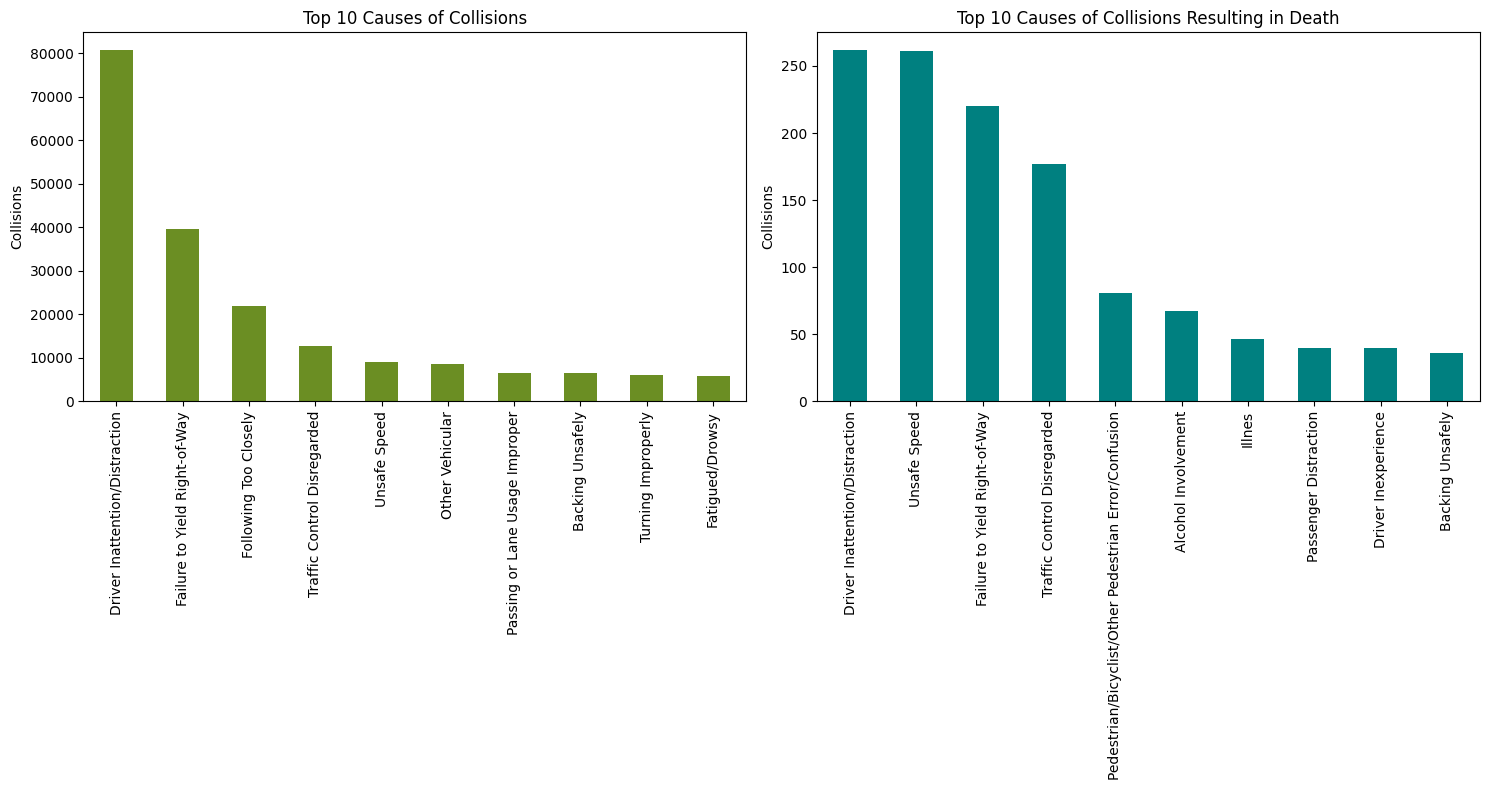

In [5]:
# initialise plot
fig, axes = plt.subplots(1,2,tight_layout=True, figsize=(15,8))
# data for all collisions in the data set
collision_per_factor = data[data['CONTRIBUTING FACTOR VEHICLE 1']!='Unspecified'][['COLLISION_ID','CONTRIBUTING FACTOR VEHICLE 1']].groupby('CONTRIBUTING FACTOR VEHICLE 1').count()
collision_per_factor = collision_per_factor.rename(columns = {'COLLISION_ID': 'NumberOfCollisions'})
collision_per_factor = collision_per_factor.sort_values('NumberOfCollisions', ascending=False)
collision_per_factor.head(10)

# plot top 10
collision_per_factor.head(10).plot.bar(ylabel='Collisions',title='Top 10 Causes of Collisions', color='olivedrab',legend=False,ax=axes[0],xlabel='')

# data for fatal collisions in the data set
collision_per_factor = data[(data['CONTRIBUTING FACTOR VEHICLE 1']!='Unspecified') & (data['PERSON KILLED FLAG']==1)][['COLLISION_ID','CONTRIBUTING FACTOR VEHICLE 1']].groupby('CONTRIBUTING FACTOR VEHICLE 1').count()
collision_per_factor = collision_per_factor.rename(columns = {'COLLISION_ID': 'NumberOfCollisions'})
collision_per_factor = collision_per_factor.sort_values('NumberOfCollisions', ascending=False)
collision_per_factor.head(10)

# plot top 10
collision_per_factor.head(10).plot.bar(ylabel='Collisions',title='Top 10 Causes of Collisions Resulting in Death', color='teal',legend=False,ax=axes[1],xlabel='')
plt.show()

it is evident that driver distractions cause the highest number of accidents. Unsafe speeds, i.e., speeding, is one of the top contributing factors for death in traffic. There is less traffic during most weekends and as such vehicles drive substantially faster on average. Furthermore, Fridays and weekends tend to also lend themselves more to the consumption of alcohol which is also in the top 10 contributing factors for traffic fatalities. This also neatly explains the peak in fatalities up and around midnight. 

As most of this project will look at how collisions are distributed geographically, I wanted to first visualise the probability of fatal collisions in the different boroughs or regions of NYC. Here I inlcuded all collisions and not just the ones that results in death and injury. This was done to accurately reflect fatality rates.

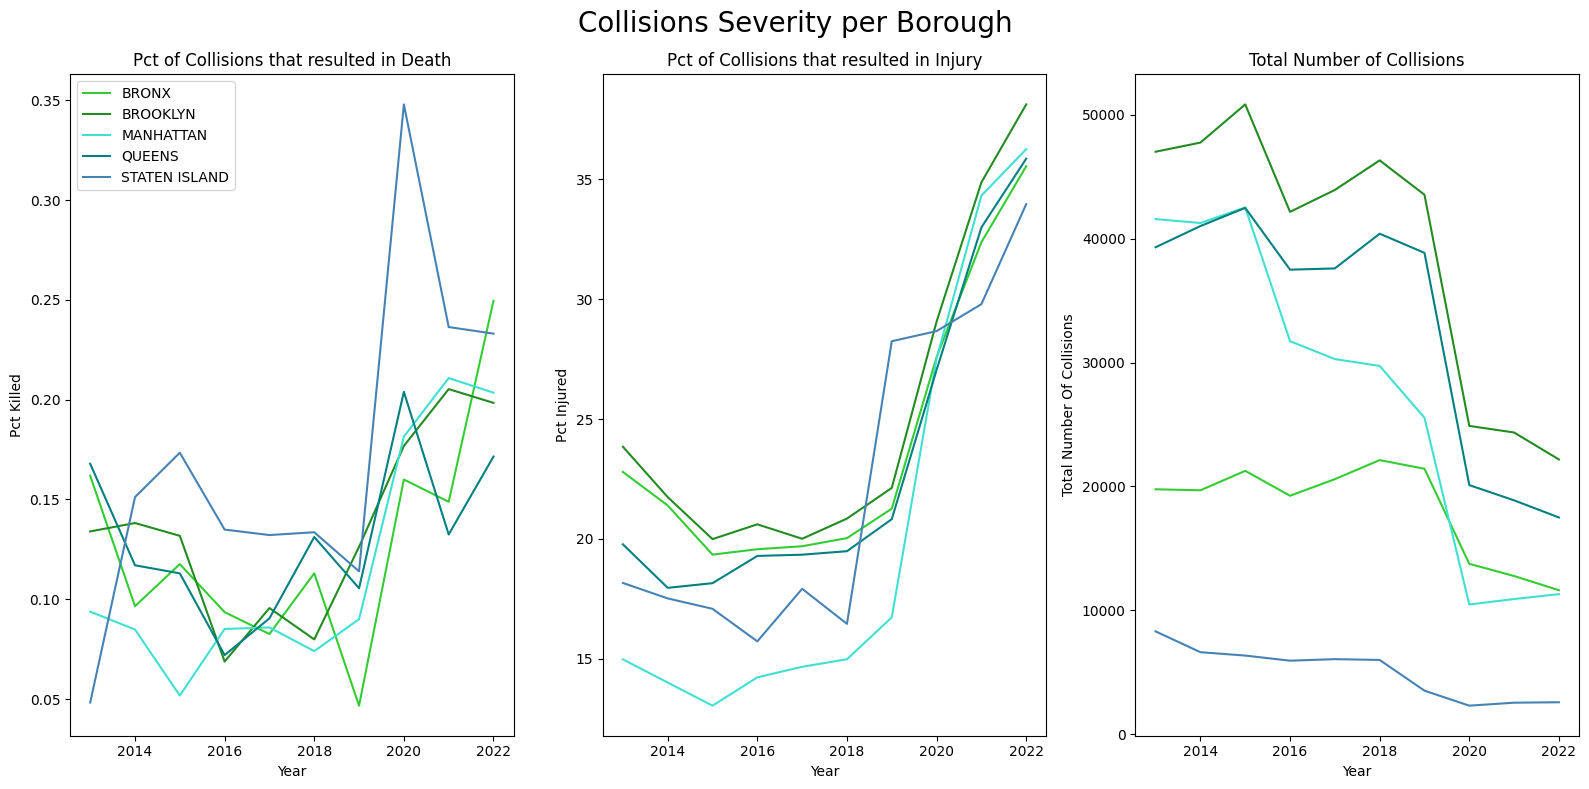

In [6]:
# compute aggregated per borough
data_ag_borough = pd.DataFrame(data_all.groupby(['year','BOROUGH'])['COLLISION_ID'].count()).reset_index()
data_ag_borough = data_ag_borough.rename(columns = {'COLLISION_ID': 'Number Of Collisions'})
data_ag_borough['KILLED'] = pd.DataFrame(data_all[data_all['PERSON KILLED FLAG']==1].groupby(['year','BOROUGH'])['COLLISION_ID'].count()).reset_index()['COLLISION_ID']
data_ag_borough['INJURED'] = pd.DataFrame(data_all[data_all['PERSON INJURED FLAG']==1].groupby(['year','BOROUGH'])['COLLISION_ID'].count()).reset_index()['COLLISION_ID']
data_ag_borough['Pct KILLED'] = (data_ag_borough['KILLED']/data_ag_borough['Number Of Collisions'])*100
data_ag_borough['Pct INJURED'] = (data_ag_borough['INJURED']/data_ag_borough['Number Of Collisions'])*100

# pivot table to prepare for plot
data_ag_borough_pivot_killed = pd.pivot_table(data_ag_borough, values='Pct KILLED', index='year',columns='BOROUGH',aggfunc='sum')
data_ag_borough_pivot_injured = pd.pivot_table(data_ag_borough, values='Pct INJURED', index='year',columns='BOROUGH',aggfunc='sum')
data_ag_borough_pivot_total = pd.pivot_table(data_ag_borough, values='Number Of Collisions', index='year',columns='BOROUGH',aggfunc='sum')
# save data frame to excel
data_ag_borough.to_excel('data/data_ag_borough.xlsx',index=False)
# plots
cols = ['limegreen','forestgreen','turquoise','teal','steelblue']

fig, axs = plt.subplots(1,3, tight_layout=True, figsize=(16,8))
fig.align_ylabels()
fig.suptitle('Collisions Severity per Borough', fontsize=20)

for i, borough in enumerate(data_ag_borough['BOROUGH'].unique()):
    axs[0].plot(data_ag_borough_pivot_killed[borough], color=cols[i])
    axs[1].plot(data_ag_borough_pivot_injured[borough], color=cols[i])
    axs[2].plot(data_ag_borough_pivot_total[borough], color=cols[i])

axs[0].set_xlabel('Year')
axs[1].set_xlabel('Year')
axs[2].set_xlabel('Year')
axs[0].set_ylabel('Pct Killed')
axs[1].set_ylabel('Pct Injured')
axs[2].set_ylabel('Total Number Of Collisions')
axs[0].set_title('Pct of Collisions that resulted in Death')
axs[1].set_title('Pct of Collisions that resulted in Injury')
axs[2].set_title('Total Number of Collisions')
axs[0].legend(data_ag_borough['BOROUGH'].unique())

plt.show()

As evident from the below plots, all boroughs are equally represented in terms of collision severity, although Staten Island seems to host, on average, more severe collisions. When we differentiate between victim types, i.e., motorists, cyclists and pedestrians, we see that pedestrians are killed more in the inner city. Queens, Staten Island and the Bronx share high motorist fatalities. This all seems to indicate that the collisions severity is somehow linked to the location of the collision.

In [7]:
# data prep for plot showing victim information
data_ag_borough['index'] = data_ag_borough['year'].astype(str)+data_ag_borough['BOROUGH']
data_ag_borough = data_ag_borough.set_index('index')

# killed
data_ag_borough_2 = pd.DataFrame(data[data['MOTORIST KILLED FLAG']==1].groupby(['year','BOROUGH'])['COLLISION_ID'].count()).reset_index()
data_ag_borough_2 = data_ag_borough_2.rename(columns = {'COLLISION_ID': 'MOTORIST KILLED'})
data_ag_borough_2['index'] = data_ag_borough_2['year'].astype(str)+data_ag_borough_2['BOROUGH']
data_ag_borough_2 = data_ag_borough_2.set_index(['index'])
data_ag_borough = data_ag_borough.join(data_ag_borough_2[['MOTORIST KILLED']])

data_ag_borough_2 = pd.DataFrame(data[data['CYCLIST KILLED FLAG']==1].groupby(['year','BOROUGH'])['COLLISION_ID'].count()).reset_index()
data_ag_borough_2 = data_ag_borough_2.rename(columns = {'COLLISION_ID': 'CYCLIST KILLED'})
data_ag_borough_2['index'] = data_ag_borough_2['year'].astype(str)+data_ag_borough_2['BOROUGH']
data_ag_borough_2 = data_ag_borough_2.set_index(['index'])
data_ag_borough = data_ag_borough.join(data_ag_borough_2[['CYCLIST KILLED']])

data_ag_borough_2 = pd.DataFrame(data[data['PEDESTRIAN KILLED FLAG']==1].groupby(['year','BOROUGH'])['COLLISION_ID'].count()).reset_index()
data_ag_borough_2 = data_ag_borough_2.rename(columns = {'COLLISION_ID': 'PEDESTRIAN KILLED'})
data_ag_borough_2['index'] = data_ag_borough_2['year'].astype(str)+data_ag_borough_2['BOROUGH']
data_ag_borough_2 = data_ag_borough_2.set_index(['index'])
data_ag_borough = data_ag_borough.join(data_ag_borough_2[['PEDESTRIAN KILLED']])

# injured
data_ag_borough_2 = pd.DataFrame(data[data['MOTORIST INJURED FLAG']==1].groupby(['year','BOROUGH'])['COLLISION_ID'].count()).reset_index()
data_ag_borough_2 = data_ag_borough_2.rename(columns = {'COLLISION_ID': 'MOTORIST INJURED'})
data_ag_borough_2['index'] = data_ag_borough_2['year'].astype(str)+data_ag_borough_2['BOROUGH']
data_ag_borough_2 = data_ag_borough_2.set_index(['index'])
data_ag_borough = data_ag_borough.join(data_ag_borough_2[['MOTORIST INJURED']])

data_ag_borough_2 = pd.DataFrame(data[data['CYCLIST INJURED FLAG']==1].groupby(['year','BOROUGH'])['COLLISION_ID'].count()).reset_index()
data_ag_borough_2 = data_ag_borough_2.rename(columns = {'COLLISION_ID': 'CYCLIST INJURED'})
data_ag_borough_2['index'] = data_ag_borough_2['year'].astype(str)+data_ag_borough_2['BOROUGH']
data_ag_borough_2 = data_ag_borough_2.set_index(['index'])
data_ag_borough = data_ag_borough.join(data_ag_borough_2[['CYCLIST INJURED']])

data_ag_borough_2 = pd.DataFrame(data[data['PEDESTRIAN INJURED FLAG']==1].groupby(['year','BOROUGH'])['COLLISION_ID'].count()).reset_index()
data_ag_borough_2 = data_ag_borough_2.rename(columns = {'COLLISION_ID': 'PEDESTRIAN INJURED'})
data_ag_borough_2['index'] = data_ag_borough_2['year'].astype(str)+data_ag_borough_2['BOROUGH']
data_ag_borough_2 = data_ag_borough_2.set_index(['index'])
data_ag_borough = data_ag_borough.join(data_ag_borough_2[['PEDESTRIAN INJURED']])

# pct compute
data_ag_borough['Pct PEDESTRIAN KILLED'] = (data_ag_borough['PEDESTRIAN KILLED']/data_ag_borough['KILLED'])*100
data_ag_borough['Pct MOTORIST KILLED'] = (data_ag_borough['MOTORIST KILLED']/data_ag_borough['KILLED'])*100
data_ag_borough['Pct CYCLIST KILLED'] = (data_ag_borough['CYCLIST KILLED']/data_ag_borough['KILLED'])*100
data_ag_borough['Pct PEDESTRIAN INJURED'] = (data_ag_borough['PEDESTRIAN INJURED']/data_ag_borough['INJURED'])*100
data_ag_borough['Pct MOTORIST INJURED'] = (data_ag_borough['MOTORIST INJURED']/data_ag_borough['INJURED'])*100
data_ag_borough['Pct CYCLIST INJURED'] = (data_ag_borough['CYCLIST INJURED']/data_ag_borough['INJURED'])*100

# show data
data_ag_borough

# save data frame to excel
data_ag_borough.to_excel('data/data_ag_borough.xlsx',index=False)

# pivot table to prepare for plot
data_ag_borough_pivot_killed_motorist = pd.pivot_table(data_ag_borough, values='Pct MOTORIST KILLED', index='year',columns='BOROUGH',aggfunc='sum')
data_ag_borough_pivot_killed_cyclist = pd.pivot_table(data_ag_borough, values='Pct CYCLIST KILLED', index='year',columns='BOROUGH',aggfunc='sum')
data_ag_borough_pivot_killed_pedestrian = pd.pivot_table(data_ag_borough, values='Pct PEDESTRIAN KILLED', index='year',columns='BOROUGH',aggfunc='sum')

data_ag_borough_pivot_injured_motorist = pd.pivot_table(data_ag_borough, values='Pct MOTORIST INJURED', index='year',columns='BOROUGH',aggfunc='sum')
data_ag_borough_pivot_injured_cyclist = pd.pivot_table(data_ag_borough, values='Pct CYCLIST INJURED', index='year',columns='BOROUGH',aggfunc='sum')

data_ag_borough_pivot_injured_pedestrian = pd.pivot_table(data_ag_borough, values='Pct PEDESTRIAN INJURED', index='year',columns='BOROUGH',aggfunc='sum')

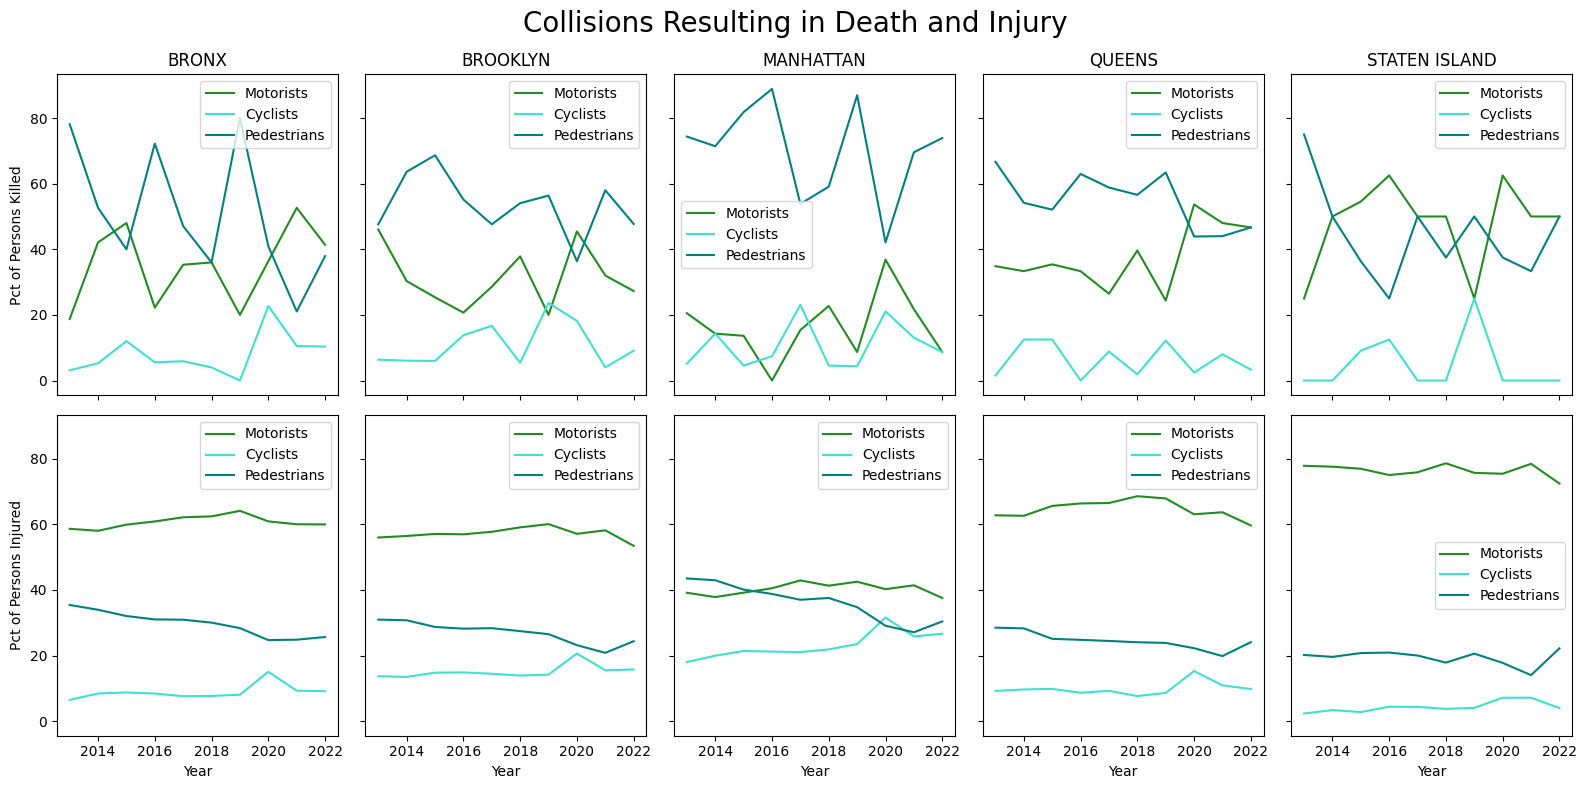

In [8]:
# plot
fig, axs = plt.subplots(2,5, tight_layout=True, figsize=(16,8), sharey=True, sharex=True)
fig.align_ylabels()
fig.suptitle('Collisions Resulting in Death and Injury', fontsize=20)

for i, borough in enumerate(data_ag_borough['BOROUGH'].unique()):
    axs.ravel()[i].plot(data_ag_borough_pivot_killed_motorist[borough], color=cols[1])
    axs.ravel()[i].plot(data_ag_borough_pivot_killed_cyclist[borough], color=cols[2])
    axs.ravel()[i].plot(data_ag_borough_pivot_killed_pedestrian[borough], color=cols[3])
    axs.ravel()[i].set_title(borough)
    axs.ravel()[i].legend(['Motorists','Cyclists','Pedestrians'])
    axs.ravel()[0].set_ylabel('Pct of Persons Killed')

for i, borough in enumerate(data_ag_borough['BOROUGH'].unique()):
    axs.ravel()[i+5].plot(data_ag_borough_pivot_injured_motorist[borough], color=cols[1])
    axs.ravel()[i+5].plot(data_ag_borough_pivot_injured_cyclist[borough], color=cols[2])
    axs.ravel()[i+5].plot(data_ag_borough_pivot_injured_pedestrian[borough], color=cols[3])
    axs.ravel()[i+5].legend(['Motorists','Cyclists','Pedestrians'])
    axs.ravel()[0+5].set_ylabel('Pct of Persons Injured')
    axs.ravel()[i+5].set_xlabel('Year')

plt.show()

Finally I wanted to visualise where fatal collisions were occuring in relation to the hospitals. Here we see that there are large areas in Queens and Staten Island that are quite far from a hospital. There seems to also be clusters forming around large intersections and highways where speeds are higher.

In [9]:
# show hospitals with 5 km range marked as circles filtered
meanlat = np.mean(data['LATITUDE'])
meanlon = np.mean(data['LONGITUDE'])

map_hospital_collision = folium.Map(location=[meanlat,meanlon], zoom_start=11,tiles = "Stamen Toner")

# plot collisions that resulted in death
HeatMap(data=data[data['PERSON KILLED FLAG']==1][['LATITUDE', 'LONGITUDE']], radius=10).add_to(map_hospital_collision)
for idx, row in data_hospitals.iterrows():
    Marker([row['lat'], row['lon']],icon=folium.Icon(color='green')).add_child(folium.Popup(row['Facility Name'])).add_to(map_hospital_collision)
    
map_hospital_collision

# save file as .html
#embed_map(map_hospital_collision, "visualisations/map_hospital_collision.html")

### Data Analysis

This section aims to highlight exactly what visualisations have been done, but also the background computations required to make said visualisations.

##### Current Hospital Configuration

The key component to the project is computing the distances between two coordinates. For this, I have chosen to implement the haversine function from the lectures, and combine it with some for loops to loop over all hospitals and choose the shortest distance.

In [10]:
# functions used to compute the distance to nearest hospital
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    
    return c * r

def nearestDistanceToHostpital(row):
    """
    Compute distance to nearest hospital for each row of the 
    'data' dataframe
    outputs in km
    """
    # allocate memory
    dists = []
    # query hospital coordinates
    lonHosSeries = data_hospitals[['lat','lon']]['lon']
    latHosSeries = data_hospitals[['lat','lon']]['lat']
    # loop over all hospitals
    for i in range(0,np.shape(data_hospitals)[0]):
        # extract coordinates of hospital
        lonHos = lonHosSeries[i]
        latHos = latHosSeries[i]
        # compute distance
        dist = haversine(row[0],row[1],lonHos,latHos)
        # append to memory
        dists.append(dist)

    nearestDist = min(dists)

    return nearestDist

def nearestHostpital(row):
    """
    Compute nearest hospital for each row of the 
    'data' dataframe
    outputs name of hospital
    """
    # allocate memory
    dists = []
    dataHos = data_hospitals[['lat','lon','Facility Name']]
    # query hospital coordinates
    lonHosSeries = dataHos['lon']
    latHosSeries = dataHos['lat']
    # loop over all hospitals
    for i in range(0,np.shape(data_hospitals)[0]):
        # extract coordinates of hospital
        lonHos = lonHosSeries[i]
        latHos = latHosSeries[i]
        # compute distance
        dist = haversine(row[0],row[1],lonHos,latHos)
        # append to memory
        dists.append(dist)

    nearestDist = min(dists)
    indexOfNearest = np.where(np.array(dists)==nearestDist)[0][0]  
    hospital = dataHos['Facility Name'][indexOfNearest]

    return hospital

In [11]:
# commpute the distance to nearest hospital
# takes a long time to compute
data['SHORTEST DISTANCE TO HOSPITAL'] = [nearestDistanceToHostpital(x) for x in data[['LONGITUDE','LATITUDE']].to_numpy().tolist()] 
# remove outliers
data = data[data['SHORTEST DISTANCE TO HOSPITAL'] < 30]
# compute name of the nearest hospital
data['NEAREST HOSPITAL'] = [nearestHostpital(x) for x in data[['LONGITUDE','LATITUDE']].to_numpy().tolist()] 

C:\Users\phili\AppData\Local\Temp\ipykernel_22652\2984322556.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



From here we can compute the distribution of shortest distance to hopsitals.

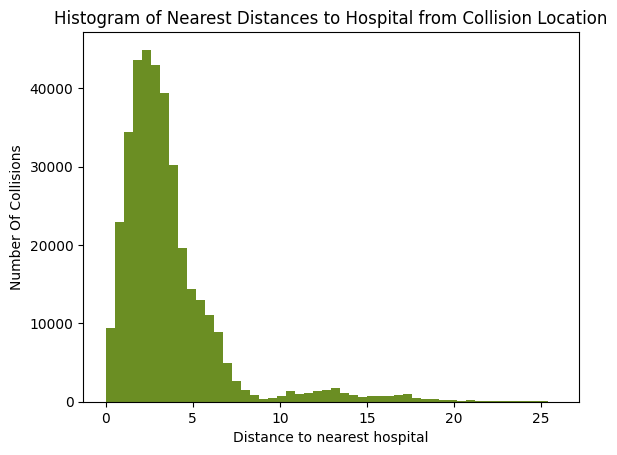

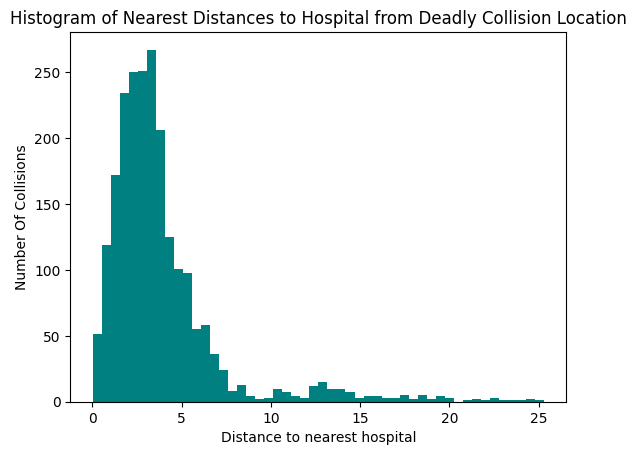

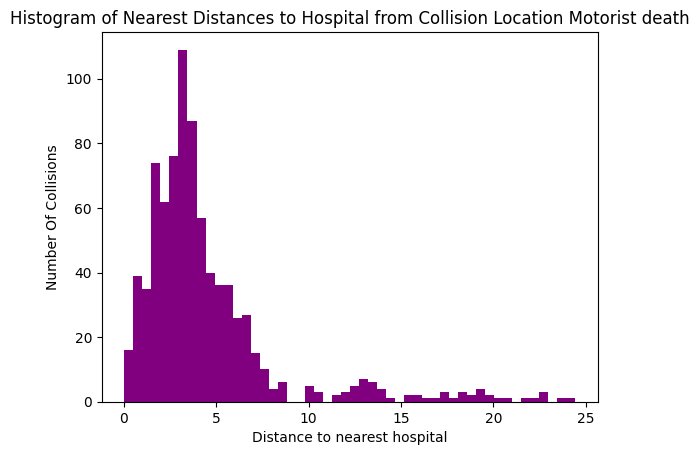

mean distance to nearest hospital 3.63 km
mean distance to nearest hospital where a person died 3.87 km
mean distance to nearest hospital where a Motorist died 4.45 km


In [12]:
# histogram representation of the nearest distance to hospital
plt.hist(data['SHORTEST DISTANCE TO HOSPITAL'], color='olivedrab',bins=50)
plt.xlabel('Distance to nearest hospital')
plt.ylabel('Number Of Collisions')
plt.title('Histogram of Nearest Distances to Hospital from Collision Location')
plt.show()

plt.hist(data[data['PERSON KILLED FLAG']==1]['SHORTEST DISTANCE TO HOSPITAL'], color='teal',bins=50)
plt.xlabel('Distance to nearest hospital')
plt.ylabel('Number Of Collisions')
plt.title('Histogram of Nearest Distances to Hospital from Deadly Collision Location')
plt.show()

plt.hist(data[data['MOTORIST KILLED FLAG']==1]['SHORTEST DISTANCE TO HOSPITAL'], color='purple',bins=50)
plt.xlabel('Distance to nearest hospital')
plt.ylabel('Number Of Collisions')
plt.title('Histogram of Nearest Distances to Hospital from Collision Location Motorist death')
plt.show()

# compute average distances
meanDist = np.mean(data['SHORTEST DISTANCE TO HOSPITAL'])
meanDistDeath = np.mean(data[data['PERSON KILLED FLAG']==1]['SHORTEST DISTANCE TO HOSPITAL'])
meanDistDeathMotorist = np.mean(data[data['MOTORIST KILLED FLAG']==1]['SHORTEST DISTANCE TO HOSPITAL'])
# print average distances
print(f'mean distance to nearest hospital {meanDist:.2f} km')
print(f'mean distance to nearest hospital where a person died {meanDistDeath:.2f} km')
print(f'mean distance to nearest hospital where a Motorist died {meanDistDeathMotorist:.2f} km')

The average distance to nearest hospital is 3.6 km (collisions where a person is injured or killed.). If we instead look at colliisons where people have died, we see that the average distance to nearest hospital is 3.9 km. The mean distance is increased even further when we focus solely on motorist deaths where the average distance is 4.6 km. Furthermore, we see that most collisions occur within a radius of 5km with some outliers that occur over 20 km away from nearest hospital.

5 km might not seem far, but according to [TomTom](https://www.tomtom.com/traffic-index/new-york-traffic/), the time it takes to travel 10 km is on average 24 min for 2022. That is 12 mins for 5 km distance. This does not consider that Ambulances travel faster on average than normal cars. However, it would still take time to call the emergency services and for the ambulance to get going. Likewise, the distance given here is the straight-line distance, which is significantly shorter than if one actually drove on the roads.

We compute new flag variables:

In [13]:
# compute distance flags
def distanceMoreThan(x,threshold):
    """
    Computes flag
    distance greater than 5 km
    """
    if x > threshold:
        result = 1
    else:
        result = 0
    return result

def isSpeeding(x):
    if x == 'Unsafe Speed':
        result = 1
    else:
        result = 0

    return result

# apply functions for flags
data['SHORTEST DISTANCE TO HOSPITAL > 3 km'] = [distanceMoreThan(x,threshold=3) for x in data['SHORTEST DISTANCE TO HOSPITAL'].to_numpy().tolist()] 
data['SHORTEST DISTANCE TO HOSPITAL > 5 km'] = [distanceMoreThan(x,threshold=5) for x in data['SHORTEST DISTANCE TO HOSPITAL'].to_numpy().tolist()] 
data['SHORTEST DISTANCE TO HOSPITAL > 10 km'] = [distanceMoreThan(x,threshold=10) for x in data['SHORTEST DISTANCE TO HOSPITAL'].to_numpy().tolist()] 
data['SHORTEST DISTANCE TO HOSPITAL > 15 km'] = [distanceMoreThan(x,threshold=15) for x in data['SHORTEST DISTANCE TO HOSPITAL'].to_numpy().tolist()] 
data['SHORTEST DISTANCE TO HOSPITAL > 20 km'] = [distanceMoreThan(x,threshold=20) for x in data['SHORTEST DISTANCE TO HOSPITAL'].to_numpy().tolist()] 

data['IS SPEEDING'] = data['CONTRIBUTING FACTOR VEHICLE 1'].apply(isSpeeding) 

We can now visualise the distribution of collisions that occure outside of the 5 km radius.

In [14]:
hospital_range5km = folium.Map(location=[40.6,-74], zoom_start=11,tiles = "Stamen Toner")

# plot collisions that resulted in death
HeatMap(data=data[data['SHORTEST DISTANCE TO HOSPITAL > 5 km']==1][['LATITUDE', 'LONGITUDE']], radius=10).add_to(hospital_range5km)
for idx, row in data_hospitals.iterrows():
    Marker([row['lat'], row['lon']]).add_child(folium.Popup(row['Facility Name'])).add_to(hospital_range5km)
    folium.Circle([row['lat'], row['lon']],radius=5000, alpha=1,color='green',fill_color='green',fill_opacity=0.2).add_to(hospital_range5km)

hospital_range5km
# save file as .html
#embed_map(map_1, "visualisations/hospital_range5km.html")

We see large areas of Staten Island and Queens that are greater than 5 km away from the nearest hospital. In fact 18.5% of collisions that result in death or injury fall outside of the 5 km radius to nearest hospital.

We compute the relative severity (how many out of the total collisions are collisions that result in fatalities) for collisions that occur within and outside of the 5 km radius to nearest hospital we see that collision occurring within the 5 km radius have a fatality rate of 0.59% whilst collisions occurring outside the radius have a fatality rate of 0.65%. If we only consider motorist deaths, the difference becomes even larger. Collisions within the 5 km radius have a motorist fatality rate of 0.20% whilst outside the radius, the fatality rate increase to 0.32%. We can compare to the average fatality rate of 0.60% and the average motorist fatality rate of 0.22%. Overall, we see that collisions occurring more than 5 km away form the nearest hospital have a higher fatality rate, especially when one considers motorist deaths. 



In [15]:
ratio = np.sum(data['SHORTEST DISTANCE TO HOSPITAL > 5 km'])/np.count_nonzero(data['COLLISION_ID'])*100
print(f'The ratio of collisions that fall outside the 5km radius to nearest hospital {ratio:.4} %')

The ratio of collisions that fall outside the 5km radius to nearest hospital 18.5 %


In [16]:
# pct mortality rates
print('Relative Fatality Rate > 5km:')
print(np.shape(data[(data['SHORTEST DISTANCE TO HOSPITAL > 5 km']==1) & (data['PERSON KILLED FLAG']==1)])[0]/np.shape(data[(data['SHORTEST DISTANCE TO HOSPITAL > 5 km']==1)])[0]*100)
print('Relative Fatality Rate < 5km:')
print(np.shape(data[(data['SHORTEST DISTANCE TO HOSPITAL > 5 km']==0) & (data['PERSON KILLED FLAG']==1)])[0]/np.shape(data[(data['SHORTEST DISTANCE TO HOSPITAL > 5 km']==0)])[0]*100)
print('Relative Fatality Rate For Motorists > 5km:')
print(np.shape(data[(data['SHORTEST DISTANCE TO HOSPITAL > 5 km']==1) & (data['MOTORIST KILLED FLAG']==1)])[0]/np.shape(data[(data['SHORTEST DISTANCE TO HOSPITAL > 5 km']==1)])[0]*100)
print('Relative Fatality Rate For Motorists < 5km:')
print(np.shape(data[(data['SHORTEST DISTANCE TO HOSPITAL > 5 km']==0) & (data['MOTORIST KILLED FLAG']==1)])[0]/np.shape(data[(data['SHORTEST DISTANCE TO HOSPITAL > 5 km']==0)])[0]*100)

Relative Fatality Rate > 5km:
0.6590594641236591
Relative Fatality Rate < 5km:
0.5951858478781945
Relative Fatality Rate For Motorists > 5km:
0.3272981537408691
Relative Fatality Rate For Motorists < 5km:
0.20289659363289558


If we assume that the hospital for which the individuals that are involved in the collision is the hospital that is closest to the accident, we can compute how many collisions each hosptital is assigned to. In this project, this metric is called hospital stress.

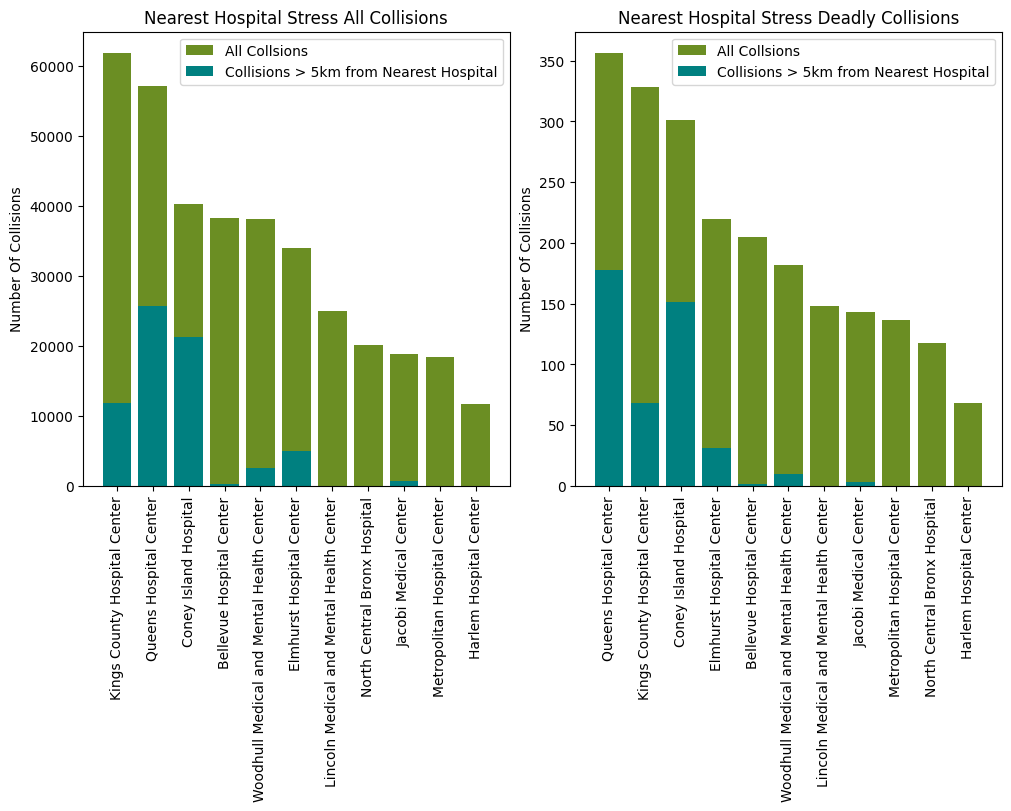

In [17]:
# compute hospital stress
fig, axes = plt.subplots(1,2,constrained_layout=True,figsize=(10,8))

hospital_stress = data[['COLLISION_ID','NEAREST HOSPITAL','SHORTEST DISTANCE TO HOSPITAL > 5 km']].groupby(['NEAREST HOSPITAL']).count()
hospital_stress = hospital_stress.rename(columns = {'COLLISION_ID': 'NumberOfCollisions'})
hospital_stress['NumberOfCollisions > 5km'] = data[data['SHORTEST DISTANCE TO HOSPITAL > 5 km']==1][['COLLISION_ID','NEAREST HOSPITAL']].groupby('NEAREST HOSPITAL').count()
hospital_stress = hospital_stress.sort_values('NumberOfCollisions', ascending=False)

# plot
axes.ravel()[0].bar(hospital_stress.index,hospital_stress['NumberOfCollisions'],color='olivedrab')
axes.ravel()[0].bar(hospital_stress.index,hospital_stress['NumberOfCollisions > 5km'],color='teal')
axes.ravel()[0].tick_params(axis='x',labelrotation=90)
axes.ravel()[0].set_ylabel('Number Of Collisions')
axes.ravel()[0].set_title('Nearest Hospital Stress All Collisions')
axes.ravel()[0].legend(['All Collsions','Collisions > 5km from Nearest Hospital'],loc='upper right')
#plt.show()

# compute hospital stress for deadly collisions
hospital_stress = data[data['PERSON KILLED FLAG']==1][['COLLISION_ID','NEAREST HOSPITAL','SHORTEST DISTANCE TO HOSPITAL > 5 km']].groupby(['NEAREST HOSPITAL']).count()
hospital_stress = hospital_stress.rename(columns = {'COLLISION_ID': 'NumberOfCollisions'})
hospital_stress['NumberOfCollisions > 5km'] = data[(data['SHORTEST DISTANCE TO HOSPITAL > 5 km']==1) & (data['PERSON KILLED FLAG']==1)][['COLLISION_ID','NEAREST HOSPITAL']].groupby('NEAREST HOSPITAL').count()
hospital_stress = hospital_stress.sort_values('NumberOfCollisions', ascending=False)

# plot
axes.ravel()[1].bar(hospital_stress.index,hospital_stress['NumberOfCollisions'],color='olivedrab')
axes.ravel()[1].bar(hospital_stress.index,hospital_stress['NumberOfCollisions > 5km'],color='teal')
axes.ravel()[1].tick_params(axis='x',labelrotation=90)
axes.ravel()[1].set_ylabel('Number Of Collisions')
axes.ravel()[1].set_title('Nearest Hospital Stress Deadly Collisions')
axes.ravel()[1].legend(['All Collsions','Collisions > 5km from Nearest Hospital'],loc='upper right')
plt.show()

Notably we see that Queens Hospital centre is the hospital that is closest to most collisions occurring more than 5 km away from the nearest hospital. In fact, around 50% of the fatal collisions the hospital receives stem from collisions occurring more than 5 km away. Kings County Hospital and Coney Island Hospital also have large proportions of distant collision patients.  

##### Additional Hospitals

Using Kmeans clustering on the coordinates of collisions that fall outside the 5 km radius to nearest hospital, we can partition the coordinates into k clusters in which each observation belongs to the cluster with the nearest mean.

We can compute the clustering score as a function of the number of clusters and define the optimal amount of cluster to be where the clustering score begins to 'flattens out'. Evidently, the optimal amount of clusters is 3 or 4. 

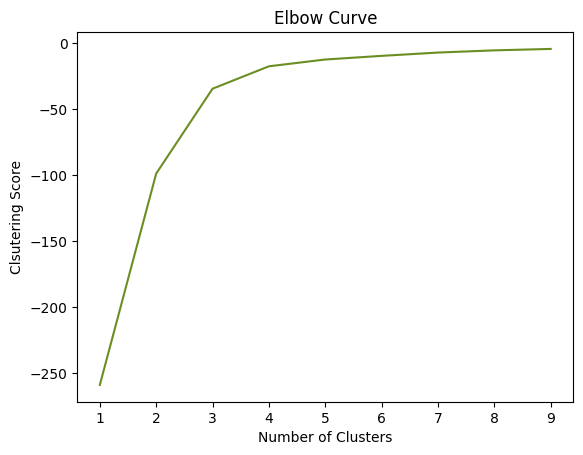

In [18]:
# compute optimal new hospital locations
clusteringData = data[data['SHORTEST DISTANCE TO HOSPITAL > 5 km']==1]

K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = clusteringData[['LATITUDE']]
X_axis = clusteringData[['LONGITUDE']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score,color='olivedrab')
plt.xlabel('Number of Clusters')
plt.ylabel('Clsutering Score')
plt.title('Elbow Curve')
plt.show()


In [19]:
# loop over all 1:10 new hospitals
averages = []

for i in range(1,6):
    # import hospital data
    data_path_hospitals = 'data/Hospitals.csv'
    # read data into dataframe
    data_hospitals = pd.read_csv(data_path_hospitals,delimiter=';')
    
    # extract coordinates from Location 1
    def extract_coordinates(s):
        result = s[s.find("(")+1:s.find(")")]
        return result

    data_hospitals['coordinates'] = data_hospitals['Location 1'].apply(extract_coordinates)
    data_hospitals[['lat', 'lon']] = ((data_hospitals['coordinates'].astype(str)).str.split(',', expand=True).astype(float))\

    # we are only interested in 'accute care hospitals' 
    data_hospitals = data_hospitals[data_hospitals['Facility Type']=='Acute Care Hospital'].reset_index(drop=True)
    data_hospitals = data_hospitals[['lat','lon','Facility Name']]
    
    # clustering
    clusteringData = data[data['SHORTEST DISTANCE TO HOSPITAL > 5 km']==1]
    
    X=clusteringData.loc[:,['COLLISION_ID','LATITUDE','LONGITUDE']]
    
    kmeans = KMeans(n_clusters = i, init ='k-means++')
    kmeans.fit(X[X.columns[1:3]]) # Compute k-means clustering.
    
    X['cluster_label'] = kmeans.fit_predict(X[X.columns[1:3]])
    centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
    
    # save new hospital locations 
    hosName = ['Hospital 1']
    for i in range(1,i):
        hosName.append(f'Hospital {i}')

    dataHosrow = pd.DataFrame({'lat': centers.T[0], 'lon' : centers.T[1], 'Facility Name': hosName})
    data_hospitals = data_hospitals.append(dataHosrow).reset_index(drop=True)

    # compute distance to the nearest hospital now with NEW HOSPITALS v2 v2 v2 v2 v2
    data['SHORTEST DISTANCE TO HOSPITAL NEW HOSPITALS test'] = [nearestDistanceToHostpital(x) for x in data[['LONGITUDE','LATITUDE']].to_numpy().tolist()] 
    data = data[data['SHORTEST DISTANCE TO HOSPITAL NEW HOSPITALS test'] < 30]
    # save mean values
    averages.append(np.mean(data['SHORTEST DISTANCE TO HOSPITAL NEW HOSPITALS test']))

C:\Users\phili\AppData\Local\Temp\ipykernel_22652\788912211.py:39: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\phili\AppData\Local\Temp\ipykernel_22652\788912211.py:39: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\phili\AppData\Local\Temp\ipykernel_22652\788912211.py:39: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\phili\AppData\Local\Temp\ipykernel_22652\788912211.py:39: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\phili\AppData\Local\Temp\ipykernel_22652\788912211.py:39: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

We can now plot the mean shortest distance to hospital after the addition of 1,2,3,4 and 5 new hosptitals whos location has been optimized using kmeans clustering.

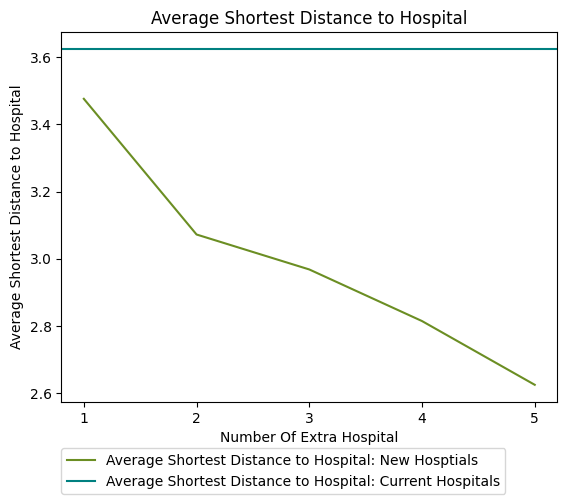

In [20]:
# plot Average Shortest Distance to Hospital as a function of additional hospitals
plt.plot(range(1,6),averages,color='olivedrab')
plt.title('Average Shortest Distance to Hospital')
plt.xlabel('Number Of Extra Hospital')
plt.ylabel('Average Shortest Distance to Hospital')
plt.axhline(y = np.mean(data['SHORTEST DISTANCE TO HOSPITAL']), color = 'teal', linestyle = '-')
plt.xticks(range(1,6))
plt.legend(['Average Shortest Distance to Hospital: New Hosptials','Average Shortest Distance to Hospital: Current Hospitals'],loc=(0, -0.25))
plt.show()

The incremental impact of additional hospitals shows that after 3 new hospitals, we can decrease the average shortest distance by 0.5 km. This small decrease is likely limited by the spread-out nature of the collisions that are more than 5 km away from the nearest hospital.

We can now add 3 more hospitals and see how it impacts the hospital coverings.

In [21]:
# re read the hospitals data
data_path_hospitals = 'data/Hospitals.csv'
# read data into dataframe
data_hospitals = pd.read_csv(data_path_hospitals,delimiter=';')

# extract coordinates from Location 1
def extract_coordinates(s):
    result = s[s.find("(")+1:s.find(")")]
    return result

data_hospitals['coordinates'] = data_hospitals['Location 1'].apply(extract_coordinates)
data_hospitals[['lat', 'lon']] = ((data_hospitals['coordinates'].astype(str)).str.split(',', expand=True).astype(float))\

# we are only interested in 'accute care hospitals' 
data_hospitals = data_hospitals[data_hospitals['Facility Type']=='Acute Care Hospital'].reset_index(drop=True)
data_hospitals = data_hospitals[['lat','lon','Facility Name']]

# define coordinates
X=clusteringData.loc[:,['COLLISION_ID','LATITUDE','LONGITUDE']]

kmeans = KMeans(n_clusters = 3, init ='k-means++')
kmeans.fit(X[X.columns[1:3]]) # Compute k-means clustering.
X['cluster_label'] = kmeans.fit_predict(X[X.columns[1:3]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
centers

# save new hospital locations 
dataHosrow1 = pd.DataFrame({'lat': [centers[0][0]], 'lon' : [centers[0][1]], 'Facility Name': ['New Hospital 1']})
dataHosrow2 = pd.DataFrame({'lat': [centers[1][0]], 'lon' : [centers[1][1]], 'Facility Name': ['New Hospital 2']})
dataHosrow3 = pd.DataFrame({'lat': [centers[2][0]], 'lon' : [centers[2][1]], 'Facility Name': ['New Hospital 3']})
data_hospitals = data_hospitals.append(dataHosrow1).reset_index(drop=True)
data_hospitals = data_hospitals.append(dataHosrow2).reset_index(drop=True)
data_hospitals = data_hospitals.append(dataHosrow3).reset_index(drop=True)

C:\Users\phili\AppData\Local\Temp\ipykernel_22652\2248338789.py:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\phili\AppData\Local\Temp\ipykernel_22652\2248338789.py:32: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\phili\AppData\Local\Temp\ipykernel_22652\2248338789.py:33: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



We can show how the new hospitals 'Hospital 1','Hospital 2','Hospital 3' cover the fatal collision that otherwise wouldnt be covered by the 5 km radius from the current NYC hospitals. 

In [35]:
# show hospitals with 5 km range marked as circles filtered
meanlat = np.mean(data['LATITUDE'])
meanlon = np.mean(data['LONGITUDE'])

map_new_hospitals = folium.Map(location=[meanlat,meanlon], zoom_start=11,tiles = "Stamen Toner")

# plot collisions that resulted in death
HeatMap(data=data[(data['PERSON KILLED FLAG']==1) & (data['SHORTEST DISTANCE TO HOSPITAL > 5 km']==1)][['LATITUDE', 'LONGITUDE']], radius=10).add_to(map_new_hospitals)
for idx, row in data_hospitals.iterrows():
    Marker([row['lat'], row['lon']]).add_child(folium.Popup(row['Facility Name'])).add_to(map_new_hospitals)
    folium.Circle([row['lat'], row['lon']],radius=5000, alpha=1,color='green',fill_color='green',fill_opacity=0.2).add_to(map_new_hospitals)

map_new_hospitals
# save file as .html
#embed_map(map_new_hospitals, "visualisations/map_new_hospitals.html")

We can now compute the new hosptial coverings and distances to nearets hospitals.

In [23]:
# compute distance to the nearest hospital now with NEW HOSPITALS 
data['SHORTEST DISTANCE TO HOSPITAL NEW HOSPITALS'] = [nearestDistanceToHostpital(x) for x in data[['LONGITUDE','LATITUDE']].to_numpy().tolist()] 
data = data[data['SHORTEST DISTANCE TO HOSPITAL NEW HOSPITALS'] < 30]

# compute name of the nearest hospital now with new hospitals
data['NEAREST HOSPITAL NEW HOSPITALS'] = [nearestHostpital(x) for x in data[['LONGITUDE','LATITUDE']].to_numpy().tolist()] 
data['SHORTEST DISTANCE TO HOSPITAL > 5 km NEW HOSPITALS'] = [distanceMoreThan(x,threshold=5) for x in data['SHORTEST DISTANCE TO HOSPITAL NEW HOSPITALS'].to_numpy().tolist()]

We can now visualise the new shortest distance to hospital distributions based on the addition of the new hospitals. 

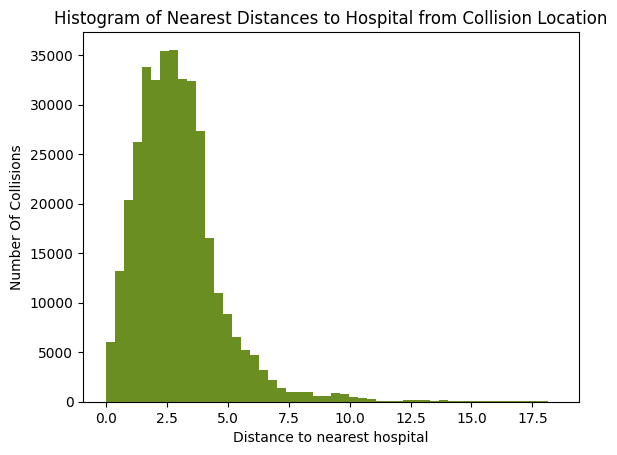

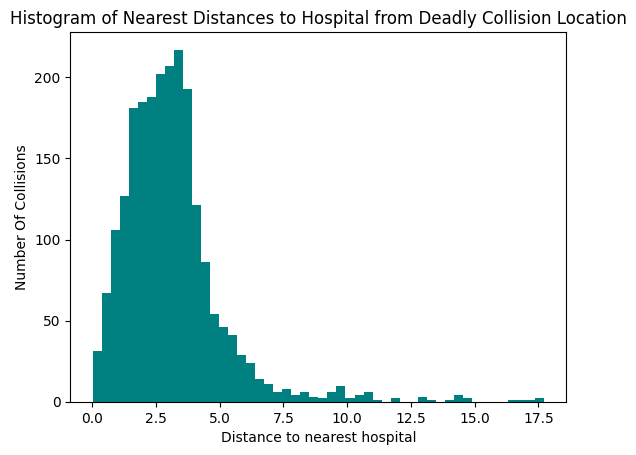

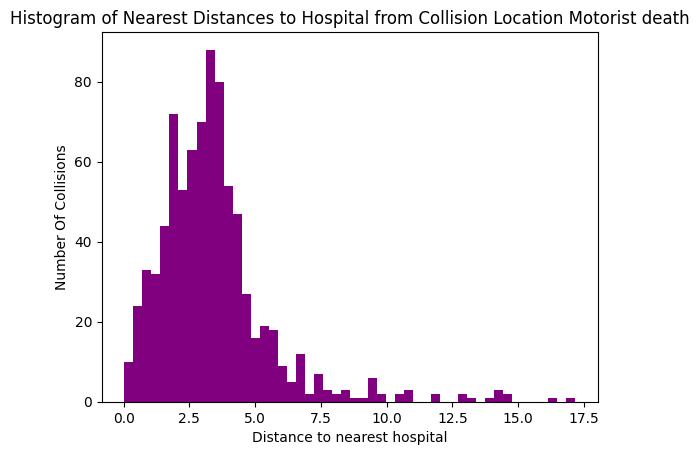

mean distance to nearest hospital 2.97 km
mean distance to nearest hospital where a person died 3.13 km
mean distance to nearest hospital where a Motorist died 3.42 km


In [24]:
# histogram representation of the nearest distance to hospital
plt.hist(data['SHORTEST DISTANCE TO HOSPITAL NEW HOSPITALS'], color='olivedrab',bins=50)
plt.xlabel('Distance to nearest hospital')
plt.ylabel('Number Of Collisions')
plt.title('Histogram of Nearest Distances to Hospital from Collision Location')
plt.show()

plt.hist(data[data['PERSON KILLED FLAG']==1]['SHORTEST DISTANCE TO HOSPITAL NEW HOSPITALS'], color='teal',bins=50)
plt.xlabel('Distance to nearest hospital')
plt.ylabel('Number Of Collisions')
plt.title('Histogram of Nearest Distances to Hospital from Deadly Collision Location')
plt.show()

plt.hist(data[data['MOTORIST KILLED FLAG']==1]['SHORTEST DISTANCE TO HOSPITAL NEW HOSPITALS'], color='purple',bins=50)
plt.xlabel('Distance to nearest hospital')
plt.ylabel('Number Of Collisions')
plt.title('Histogram of Nearest Distances to Hospital from Collision Location Motorist death')
plt.show()

# compute average distances
meanDist = np.mean(data['SHORTEST DISTANCE TO HOSPITAL NEW HOSPITALS'])
meanDistDeath = np.mean(data[data['PERSON KILLED FLAG']==1]['SHORTEST DISTANCE TO HOSPITAL NEW HOSPITALS'])
meanDistDeathMotorist = np.mean(data[data['MOTORIST KILLED FLAG']==1]['SHORTEST DISTANCE TO HOSPITAL NEW HOSPITALS'])
# print average distances
print(f'mean distance to nearest hospital {meanDist:.2f} km')
print(f'mean distance to nearest hospital where a person died {meanDistDeath:.2f} km')
print(f'mean distance to nearest hospital where a Motorist died {meanDistDeathMotorist:.2f} km')

In [25]:
ratio = np.sum(data['SHORTEST DISTANCE TO HOSPITAL > 5 km NEW HOSPITALS'])/np.count_nonzero(data['COLLISION_ID'])*100
print(f'The ratio of collisions that fall outside the 5km radius to nearest hospital {ratio:.4} %')

# pct mortality rates
print('Relative Fatality Rate > 5km:')
print(np.shape(data[(data['SHORTEST DISTANCE TO HOSPITAL > 5 km NEW HOSPITALS']==1) & (data['PERSON KILLED FLAG']==1)])[0]/np.shape(data[(data['SHORTEST DISTANCE TO HOSPITAL > 5 km NEW HOSPITALS']==1)])[0]*100)
print('Relative Fatality Rate < 5km:')
print(np.shape(data[(data['SHORTEST DISTANCE TO HOSPITAL > 5 km NEW HOSPITALS']==0) & (data['PERSON KILLED FLAG']==1)])[0]/np.shape(data[(data['SHORTEST DISTANCE TO HOSPITAL > 5 km NEW HOSPITALS']==0)])[0]*100)
print('Relative Fatality Rate For Motorists > 5km:')
print(np.shape(data[(data['SHORTEST DISTANCE TO HOSPITAL > 5 km NEW HOSPITALS']==1) & (data['MOTORIST KILLED FLAG']==1)])[0]/np.shape(data[(data['SHORTEST DISTANCE TO HOSPITAL > 5 km NEW HOSPITALS']==1)])[0]*100)
print('Relative Fatality Rate For Motorists < 5km:')
print(np.shape(data[(data['SHORTEST DISTANCE TO HOSPITAL > 5 km NEW HOSPITALS']==0) & (data['MOTORIST KILLED FLAG']==1)])[0]/np.shape(data[(data['SHORTEST DISTANCE TO HOSPITAL > 5 km NEW HOSPITALS']==0)])[0]*100)

The ratio of collisions that fall outside the 5km radius to nearest hospital 9.814 %
Relative Fatality Rate > 5km:
0.6701059832894073
Relative Fatality Rate < 5km:
0.6001324135574397
Relative Fatality Rate For Motorists > 5km:
0.3196321426568721
Relative Fatality Rate For Motorists < 5km:
0.21570595647438226


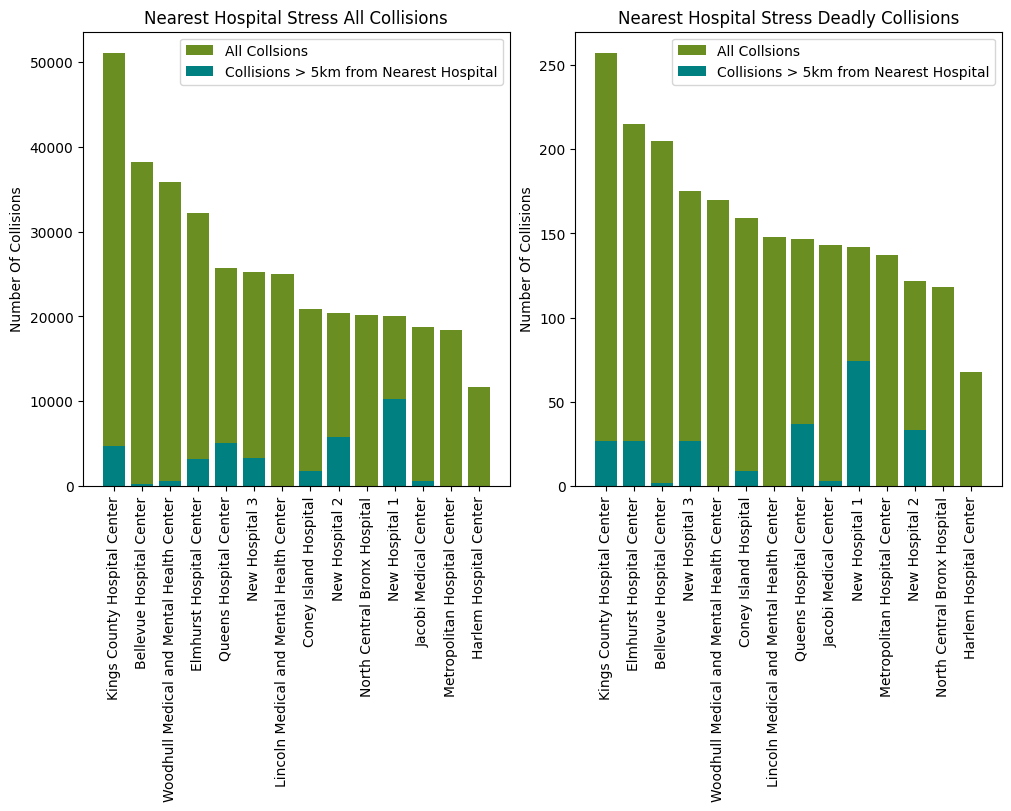

In [26]:
fig, axes = plt.subplots(1,2,constrained_layout=True,figsize=(10,8))

hospital_stress = data[['COLLISION_ID','NEAREST HOSPITAL NEW HOSPITALS','SHORTEST DISTANCE TO HOSPITAL > 5 km NEW HOSPITALS']].groupby(['NEAREST HOSPITAL NEW HOSPITALS']).count()
hospital_stress = hospital_stress.rename(columns = {'COLLISION_ID': 'NumberOfCollisions NEW HOSPITALS'})
hospital_stress['NumberOfCollisions > 5km NEW HOSPITALS'] = data[data['SHORTEST DISTANCE TO HOSPITAL > 5 km NEW HOSPITALS']==1][['COLLISION_ID','NEAREST HOSPITAL NEW HOSPITALS']].groupby('NEAREST HOSPITAL NEW HOSPITALS').count()
hospital_stress = hospital_stress.sort_values('NumberOfCollisions NEW HOSPITALS', ascending=False)

# plot
axes.ravel()[0].bar(hospital_stress.index,hospital_stress['NumberOfCollisions NEW HOSPITALS'],color='olivedrab')
axes.ravel()[0].bar(hospital_stress.index,hospital_stress['NumberOfCollisions > 5km NEW HOSPITALS'],color='teal')
axes.ravel()[0].tick_params(axis='x',labelrotation=90)
axes.ravel()[0].set_ylabel('Number Of Collisions')
axes.ravel()[0].set_title('Nearest Hospital Stress All Collisions')
axes.ravel()[0].legend(['All Collsions','Collisions > 5km from Nearest Hospital'],loc='upper right')
#plt.show()

# compute hospital stress for deadly collisions
hospital_stress = data[data['PERSON KILLED FLAG']==1][['COLLISION_ID','NEAREST HOSPITAL NEW HOSPITALS','SHORTEST DISTANCE TO HOSPITAL > 5 km NEW HOSPITALS']].groupby(['NEAREST HOSPITAL NEW HOSPITALS']).count()
hospital_stress = hospital_stress.rename(columns = {'COLLISION_ID': 'NumberOfCollisions NEW HOSPITALS'})
hospital_stress['NumberOfCollisions > 5km NEW HOSPITALS'] = data[(data['SHORTEST DISTANCE TO HOSPITAL > 5 km NEW HOSPITALS']==1) & (data['PERSON KILLED FLAG']==1)][['COLLISION_ID','NEAREST HOSPITAL NEW HOSPITALS']].groupby('NEAREST HOSPITAL NEW HOSPITALS').count()
hospital_stress = hospital_stress.sort_values('NumberOfCollisions NEW HOSPITALS' , ascending=False)

# plot
axes.ravel()[1].bar(hospital_stress.index,hospital_stress['NumberOfCollisions NEW HOSPITALS'],color='olivedrab')
axes.ravel()[1].bar(hospital_stress.index,hospital_stress['NumberOfCollisions > 5km NEW HOSPITALS'],color='teal')
axes.ravel()[1].tick_params(axis='x',labelrotation=90)
axes.ravel()[1].set_ylabel('Number Of Collisions')
axes.ravel()[1].set_title('Nearest Hospital Stress Deadly Collisions')
axes.ravel()[1].legend(['All Collsions','Collisions > 5km from Nearest Hospital'],loc='upper right')
plt.show()

##### Relocation of Existing Hospitals

Now instead of adding more hospitals to the existing ones, we shall now rearrange the existing ones to see how much better we can distribute hospitals for vehicular accident coverage. We start by using kmeans 11 clustering for 11 hospitals annd compute the distance to nearest hospital for all collisions.

In [27]:
# now for changing where existing hospitals are located
clusteringData = data
X=clusteringData.loc[:,['COLLISION_ID','LATITUDE','LONGITUDE']]
kmeans = KMeans(n_clusters = 11, init ='k-means++')
kmeans.fit(X[X.columns[1:3]]) # Compute k-means clustering.
X['cluster_label'] = kmeans.fit_predict(X[X.columns[1:3]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
centers

# save new hospital locations 
hosName = []
for i in range(1,12):
    hosName.append(f'Hospital {i}')

data_hospitals = pd.DataFrame({'lat': centers.T[0], 'lon' : centers.T[1], 'Facility Name': hosName})

In [28]:
# compute distance to the nearest hospital now with NEW HOSPITALS v2 v2 v2 v2 v2
data['SHORTEST DISTANCE TO HOSPITAL NEW HOSPITALS v2'] = [nearestDistanceToHostpital(x) for x in data[['LONGITUDE','LATITUDE']].to_numpy().tolist()] 
data = data[data['SHORTEST DISTANCE TO HOSPITAL NEW HOSPITALS v2'] < 30]

# compute name of the nearest hospital now with new hospitals
data['NEAREST HOSPITAL NEW HOSPITALS v2'] = [nearestHostpital(x) for x in data[['LONGITUDE','LATITUDE']].to_numpy().tolist()] 
data['SHORTEST DISTANCE TO HOSPITAL > 5 km NEW HOSPITALS v2'] = [distanceMoreThan(x,threshold=5) for x in data['SHORTEST DISTANCE TO HOSPITAL NEW HOSPITALS v2'].to_numpy().tolist()] 

We can naturally map new hospital locations out alongside collision fatalities. It is immediately obvious that the relocated hospitals make a significantly better covering.

In [29]:
# show hospitals with 5 km range marked as circles filtered
meanlat = np.mean(data['LATITUDE'])
meanlon = np.mean(data['LONGITUDE'])

map_new_hospitals_v2 = folium.Map(location=[meanlat,meanlon], zoom_start=11,tiles = "Stamen Toner")

# plot collisions that resulted in death
HeatMap(data=data[(data['PERSON KILLED FLAG']==1)][['LATITUDE', 'LONGITUDE']], radius=10).add_to(map_new_hospitals_v2)
for idx, row in data_hospitals.iterrows():
    Marker([row['lat'], row['lon']]).add_child(folium.Popup(row['Facility Name'])).add_to(map_new_hospitals_v2)
    folium.Circle([row['lat'], row['lon']],radius=5000, alpha=1,color='green',fill_color='green',fill_opacity=0.2).add_to(map_new_hospitals_v2)

map_new_hospitals_v2

# save file as .html
#embed_map(map_new_hospitals_v2, "visualisations/map_new_hospitals_v2.html")

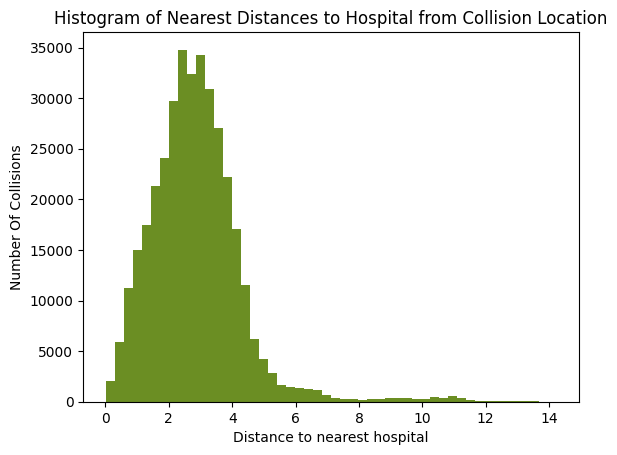

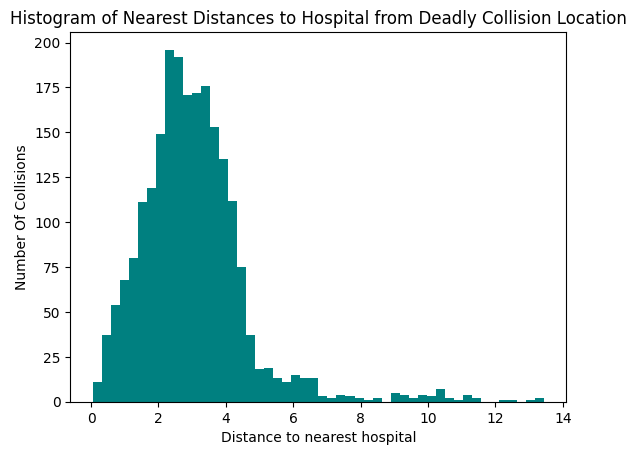

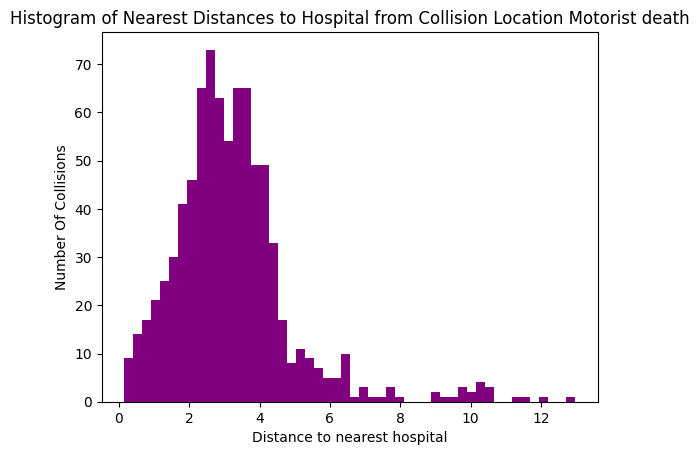

mean distance to nearest hospital 2.85 km
mean distance to nearest hospital where a person died 3.04 km
mean distance to nearest hospital where a Motorist died 3.22 km


In [30]:
# histogram representation of the nearest distance to hospital
plt.hist(data['SHORTEST DISTANCE TO HOSPITAL NEW HOSPITALS v2'], color='olivedrab',bins=50)
plt.xlabel('Distance to nearest hospital')
plt.ylabel('Number Of Collisions')
plt.title('Histogram of Nearest Distances to Hospital from Collision Location')
plt.show()

plt.hist(data[data['PERSON KILLED FLAG']==1]['SHORTEST DISTANCE TO HOSPITAL NEW HOSPITALS v2'], color='teal',bins=50)
plt.xlabel('Distance to nearest hospital')
plt.ylabel('Number Of Collisions')
plt.title('Histogram of Nearest Distances to Hospital from Deadly Collision Location')
plt.show()

plt.hist(data[data['MOTORIST KILLED FLAG']==1]['SHORTEST DISTANCE TO HOSPITAL NEW HOSPITALS v2'], color='purple',bins=50)
plt.xlabel('Distance to nearest hospital')
plt.ylabel('Number Of Collisions')
plt.title('Histogram of Nearest Distances to Hospital from Collision Location Motorist death')
plt.show()

# compute average distances
meanDist = np.mean(data['SHORTEST DISTANCE TO HOSPITAL NEW HOSPITALS v2'])
meanDistDeath = np.mean(data[data['PERSON KILLED FLAG']==1]['SHORTEST DISTANCE TO HOSPITAL NEW HOSPITALS v2'])
meanDistDeathMotorist = np.mean(data[data['MOTORIST KILLED FLAG']==1]['SHORTEST DISTANCE TO HOSPITAL NEW HOSPITALS v2'])
# print average distances
print(f'mean distance to nearest hospital {meanDist:.2f} km')
print(f'mean distance to nearest hospital where a person died {meanDistDeath:.2f} km')
print(f'mean distance to nearest hospital where a Motorist died {meanDistDeathMotorist:.2f} km')

In [31]:
ratio = np.sum(data['SHORTEST DISTANCE TO HOSPITAL > 5 km NEW HOSPITALS v2'])/np.count_nonzero(data['COLLISION_ID'])*100
print(f'The ratio of collisions that fall outside the 5km radius to nearest hospital {ratio:.4} %')

# pct mortality rates
print('Relative Fatality Rate > 5km:')
print(np.shape(data[(data['SHORTEST DISTANCE TO HOSPITAL > 5 km NEW HOSPITALS v2']==1) & (data['PERSON KILLED FLAG']==1)])[0]/np.shape(data[(data['SHORTEST DISTANCE TO HOSPITAL > 5 km NEW HOSPITALS v2']==1)])[0]*100)
print('Relative Fatality Rate < 5km:')
print(np.shape(data[(data['SHORTEST DISTANCE TO HOSPITAL > 5 km NEW HOSPITALS v2']==0) & (data['PERSON KILLED FLAG']==1)])[0]/np.shape(data[(data['SHORTEST DISTANCE TO HOSPITAL > 5 km NEW HOSPITALS v2']==0)])[0]*100)
print('Relative Fatality Rate For Motorists > 5km:')
print(np.shape(data[(data['SHORTEST DISTANCE TO HOSPITAL > 5 km NEW HOSPITALS v2']==1) & (data['MOTORIST KILLED FLAG']==1)])[0]/np.shape(data[(data['SHORTEST DISTANCE TO HOSPITAL > 5 km NEW HOSPITALS v2']==1)])[0]*100)
print('Relative Fatality Rate For Motorists < 5km:')
print(np.shape(data[(data['SHORTEST DISTANCE TO HOSPITAL > 5 km NEW HOSPITALS v2']==0) & (data['MOTORIST KILLED FLAG']==1)])[0]/np.shape(data[(data['SHORTEST DISTANCE TO HOSPITAL > 5 km NEW HOSPITALS v2']==0)])[0]*100)

The ratio of collisions that fall outside the 5km radius to nearest hospital 4.907 %
Relative Fatality Rate > 5km:
0.8298755186721992
Relative Fatality Rate < 5km:
0.5954981727060443
Relative Fatality Rate For Motorists > 5km:
0.43175956039026575
Relative Fatality Rate For Motorists < 5km:
0.21528213823775363


We note that after the relocation of all 11 hospitals, we are left with a mean shortest distance to hospital of 2.85 km, which is shorter than the addition of 5 extra hospitals to the current hospital configuration. Furthermore, we can see that the collisions are assigned alot more uniformly between the hospitals or cluster centers. However, when we look at fatality rates the picture is not as good. We see a relative fatality rate of 0.77% outside of the 5 km radius and 0.59% within the 5 km radius. For motorists its 0.40% and 0.21% respectively. This naturally means that the hospital coverage covers less of the fatal accidents than the original setup. This is likely due to the worse coverage within the city center where most pedestrian accidents occur and as we have seen, pedestrians are far more likely to die in an accident.

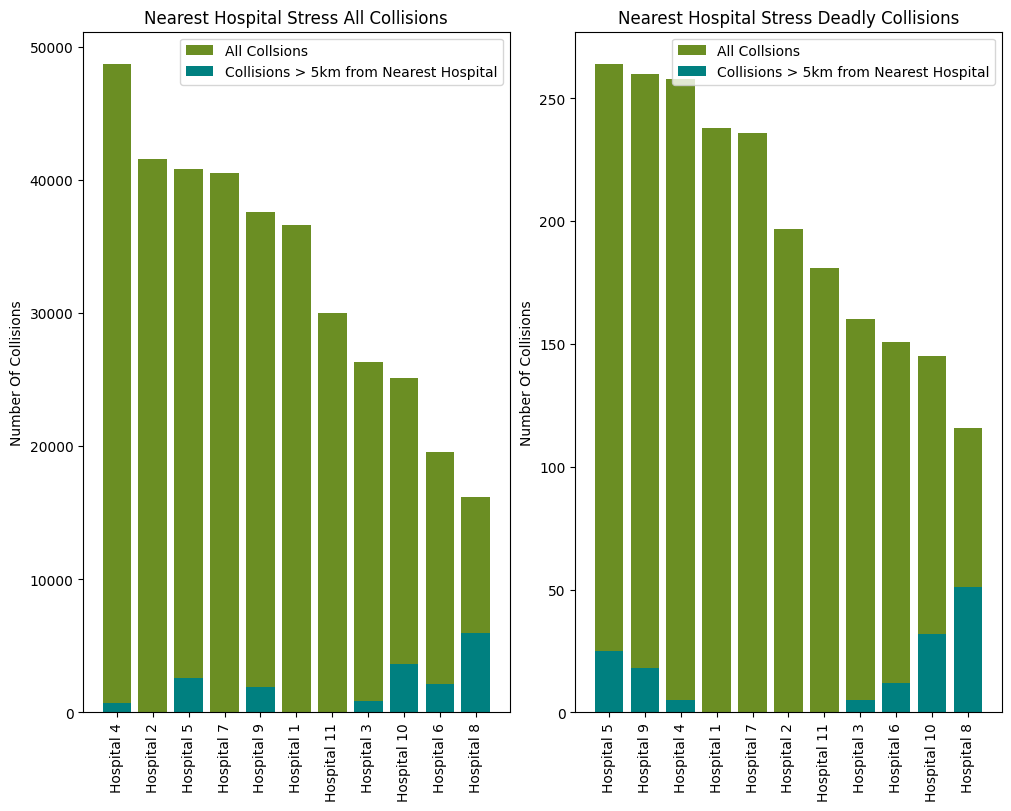

In [32]:
fig, axes = plt.subplots(1,2,constrained_layout=True,figsize=(10,8))

hospital_stress = data[['COLLISION_ID','NEAREST HOSPITAL NEW HOSPITALS v2','SHORTEST DISTANCE TO HOSPITAL > 5 km NEW HOSPITALS v2']].groupby(['NEAREST HOSPITAL NEW HOSPITALS v2']).count()
hospital_stress = hospital_stress.rename(columns = {'COLLISION_ID': 'NumberOfCollisions NEW HOSPITALS v2'})
hospital_stress['NumberOfCollisions > 5km NEW HOSPITALS v2'] = data[data['SHORTEST DISTANCE TO HOSPITAL > 5 km NEW HOSPITALS v2']==1][['COLLISION_ID','NEAREST HOSPITAL NEW HOSPITALS v2']].groupby('NEAREST HOSPITAL NEW HOSPITALS v2').count()
hospital_stress = hospital_stress.sort_values('NumberOfCollisions NEW HOSPITALS v2', ascending=False)

# plot
axes.ravel()[0].bar(hospital_stress.index,hospital_stress['NumberOfCollisions NEW HOSPITALS v2'],color='olivedrab')
axes.ravel()[0].bar(hospital_stress.index,hospital_stress['NumberOfCollisions > 5km NEW HOSPITALS v2'],color='teal')
axes.ravel()[0].tick_params(axis='x',labelrotation=90)
axes.ravel()[0].set_ylabel('Number Of Collisions')
axes.ravel()[0].set_title('Nearest Hospital Stress All Collisions')
axes.ravel()[0].legend(['All Collsions','Collisions > 5km from Nearest Hospital'],loc='upper right')
#plt.show()

# compute hospital stress for deadly collisions
hospital_stress = data[data['PERSON KILLED FLAG']==1][['COLLISION_ID','NEAREST HOSPITAL NEW HOSPITALS v2','SHORTEST DISTANCE TO HOSPITAL > 5 km NEW HOSPITALS v2']].groupby(['NEAREST HOSPITAL NEW HOSPITALS v2']).count()
hospital_stress = hospital_stress.rename(columns = {'COLLISION_ID': 'NumberOfCollisions NEW HOSPITALS v2'})
hospital_stress['NumberOfCollisions > 5km NEW HOSPITALS v2'] = data[(data['SHORTEST DISTANCE TO HOSPITAL > 5 km NEW HOSPITALS v2']==1) & (data['PERSON KILLED FLAG']==1)][['COLLISION_ID','NEAREST HOSPITAL NEW HOSPITALS v2']].groupby('NEAREST HOSPITAL NEW HOSPITALS v2').count()
hospital_stress = hospital_stress.sort_values('NumberOfCollisions NEW HOSPITALS v2' , ascending=False)

# plot
axes.ravel()[1].bar(hospital_stress.index,hospital_stress['NumberOfCollisions NEW HOSPITALS v2'],color='olivedrab')
axes.ravel()[1].bar(hospital_stress.index,hospital_stress['NumberOfCollisions > 5km NEW HOSPITALS v2'],color='teal')
axes.ravel()[1].tick_params(axis='x',labelrotation=90)
axes.ravel()[1].set_ylabel('Number Of Collisions')
axes.ravel()[1].set_title('Nearest Hospital Stress Deadly Collisions')
axes.ravel()[1].legend(['All Collsions','Collisions > 5km from Nearest Hospital'],loc='upper right')
plt.show()


In terms of hospital stress we still see a far more uniform distribution when compared to the original setup.

### Genre


An interactive magazine with linear structre was chosen for the genre of the website.

##### Visual Narrative Tools

- Consistent visual platform: We have mostly the same kind of plots throughout the data analysis section to easier be able to narrate changes.

- Zooming: We have used zooming for alot of the interactive plots in the website. This was to make it easier for users to explore the data set without holder their hand too much in the process. It was one of our aims to create an interactive user experience where zooming is key in this case.

- Feature distinction: We used feature distinction in the geo plots to visually distinguish hospitals and the hospital ranges.

##### Narrative Structure Tools

- Hover Highlighting / Details: Once more used in the pie charts and geo plots shown on the website. This was again chosen for the increased amount of interactivity with the user.

- Filtering / Selection / Search: Used when selecting between different distance distributions. This was again chosen for the increased amount of interactivity with the user.

- Linear: we chose to go with linear structure that helps guide the user and keeps the content organised and makes it easier to tell a cohenent and well structured story with data.

### Visualizations

- Pie charts: The pie charts were chosen to visualise the proportions of the victim representation in the data set. This was done as most people have an intuitive sense for what a pie chart shows and it serves as an introductory visualisation to slowly reel the user into more complex plots. The proportions are also different enough that the sizes are easily distinguishable. Futhermore, they are slightly interactive in that one can hover over to get the specific number.

- Time series plots: The time series plots were used to define some context to the data set and vehicular collisions as a whole. It was also there to introduce some tendencies that most users can relate to, like rush hour traffic and weekend binge drinking :).  

- Geo time series plots: The geo heatmap evolving with years was there to provide more contextual information, much like the regular time series plots, but include a more visually appealing map of NYC postal codes that change in color. Again, this was to reel the user in and show them a cool plot. 

- Geo heat maps: The folium heat maps were arguablly the main visualisations used in the project. They are highly interactive and show changes to geographic distributions nicely. Especially when we highligh hospitals and their ranges.

- Histograms: The blokeh interactive histograms where used for their interactive nature. That and they show distributions in a very inuitive way, which was key for user interpretability.

- Bar charts: The bar charts where chose for the ease of interpretability and to aid in visualising differences in magnitudes.

### Discussion

##### What went well?

I think that the visualisations of how additional hospitals/rearranging existing hospitals, impact the mean shortest distance to hospital. The results are neat and easily interpretable using the folium heat maps. I also think comparing fatal collisions to all other collisions was a key component to the analysis and was a theme throughout the project. Fatal collisions show the potential of hospitals. Overall I believe the interactivity with the plots really aid in the overall user experience and makes it far more interesting to play around with and investigate as an end user. 

##### What is still missing? What could be improved?, Why?

I quickly found out that the distance to hospitals didnt play a huge role in the fatality of the collisions which made the histograms not as easy to read. I would also have included weather information to the data set if time had allowed. I believe that weather conditions play a bigger role but a potential issue would be how to combine weather and distance to hospitals and still have a focused narrative to show. I would also include speed limit information as a proxy for the speed at impact to make further splits in the data perhaps revealing some tendencies. Including a 'metric' of collisions severity that combines alot of collisions information like number of killed and injured, speed, speeding flag etc to quantify the severity would have aided in the narrative. However, a potential downside to this is that severity would no longer be directly linked to something as tangible as injured and deaths.

### Contributions

I am the sole member of the group and as such I am responsible for everything.